# Latar Belakang

Taksi merupakan sebuah moda transportasi yang paling ikonik di New York, dan telah menjadi bagian dari sejarah dari negara bagian New York. TLC New York ingin melihat karakteristik penggunaan taksi berdasarkan data trip record Januari 2023.

Poin-poin yang harus dianalisa adalah:

* Karakteristik penggunaan taksi berdasarkan distribusi jumlah penumpang. Apakah mayoritas perjalanan taksi dilakukan ol penumpang tunggal atau ada banyak perjalanan dengan penumpang lebih dari satu?
* Titik penjemputan terbanyak. Apakah ada perbedaan signifikan dalam tingkat penggunaan antara lokasi-lokasi ini? Dan bagaimana perbedaan rata-rata pendapatan antara 5 tempat teratas titik jemputnya. Apakah waktu dimana

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from scipy.stats import ttest_ind, f_oneway

import warnings
warnings.filterwarnings("ignore")

# Data Preparation

Dataset ini menampilkan tanggal dan jam dimana taxi tersebut menaikkan dan menurunkan penumpang, lokasi naik dan turun penumpang, rate tarif berdasarkan tempat naiknya penumpang, jumlah penumpang yang naik, jarak tempuh, dan total yang harus dibayarkan oleh penumpang. Terdapat 20 kolom dalam dataset ini untuk diteliti

* **VendorID**: Kode yang menindikasikan provider pada LPEP. 1 = Creative Mobile Technologies, LLC. | 2 = VeriFone Inc.
* **lpep_pickup_datetime**: Tanggal dan jam argometer taksi dinyalakan.
* **lpep_dropoff_datetime**: Tanggal dan jam argometer taksi dimatikan.
* **Passenger_count**: Jumlah penumpang dalam satu mobil.
* **PULocationID** & **DOLocationID**: ID lokasi dimana penumpang diangkut (PU) dan diturunkan (DO)
* **RatecodeID**: Kode yang mengindikasikan jenis tarif yang digunakan, 1. Tarif standar | 2. JFK Airport | 3. Newark Airport | 4. Nassau & Westchester | 5. Negotiated Fare | 6. Group Ride
* **trip_distance**: Jarak tempuh taksi (dalam satuan Mile)
* **fare_amount**: Akumulasi total harga dari jarak tempuh dan waktu tempuh
* **extra**: Tambahan dan biaya tambahan lainnya. Saat ini, ini hanya mencakup $0,50 dan $1 biaya per jam sibuk dan biaya tengah malam.
* **Mta_tax**: Pajak sebesar $0,50 untuk perjalanan taksi yang dikenakan berdasarkan pasal 29-A Undang-Undang Pajak Negara Bagian New York.
* **tip_amount**: Jumlah tip yang diberikan penumpang kepada supir, data yang tercatat hanya bagi pengguna kartu kredit
* **tolls_amount**: Jumlah total semua tol yang dibayarkan dalam perjalanan.
* **improvement_surcharge**: Biaya tambahan per-perjalanan sebesar $0,30
* **total_amount**: Total tagihan yang harus dibayarkan oleh penumpan
* **payment_type**: Kode numerik jenis pembayaran 1. Credit card | 2. Cash | 3. No charge | 4. Dispute | 5. Unknown | 6. Voided trip
* **trip_type**: Kode numerik untuk jenis pemanggilan taksi. 1. Dipanggil di jalan | 2. Dipesan lewat operator taxi
* **congestion_surcharge**: Biaya tambahan yang berlaku apabila kendaraan melewati: Memulai dan mengakhiri perjalanan di New York State; dan Memulai, mengakhiri, atau melewati Manhattan, bagian selatan dari dan terkecuali 96th Street (an area known as the congestion zone)

## Data Read

In [2]:
df = pd.read_csv('NYC TLC Trip Record.csv')
df

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0             2  2023-01-01 00:26:10   2023-01-01 00:37:11                  N   
1             2  2023-01-01 00:51:03   2023-01-01 00:57:49                  N   
2             2  2023-01-01 00:35:12   2023-01-01 00:41:32                  N   
3             1  2023-01-01 00:13:14   2023-01-01 00:19:03                  N   
4             1  2023-01-01 00:33:04   2023-01-01 00:39:02                  N   
...         ...                  ...                   ...                ...   
68206         2  2023-01-31 22:29:00   2023-01-31 22:42:00                NaN   
68207         2  2023-01-31 22:40:00   2023-01-31 22:48:00                NaN   
68208         2  2023-01-31 23:46:00   2023-02-01 00:02:00                NaN   
68209         2  2023-01-31 23:01:00   2023-01-31 23:19:00                NaN   
68210         2  2023-01-31 23:51:00   2023-02-01 00:07:00                NaN   

       RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0             1.0           166           143              1.0           2.58   
1             1.0            24            43              1.0           1.81   
2             1.0           223           179              1.0           0.00   
3             1.0            41           238              1.0           1.30   
4             1.0            41            74              1.0           1.10   
...           ...           ...           ...              ...            ...   
68206         NaN            49            62              NaN        4070.82   
68207         NaN            10           205              NaN           2.14   
68208         NaN            66            37              NaN           3.44   
68209         NaN           225           189              NaN           3.03   
68210         NaN           256           140              NaN           5.82   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0            14.90    1.0      0.5        4.03           0.0        NaN   
1            10.70    1.0      0.5        2.64           0.0        NaN   
2             7.20    1.0      0.5        1.94           0.0        NaN   
3             6.50    0.5      1.5        1.70           0.0        NaN   
4             6.00    0.5      1.5        0.00           0.0        NaN   
...            ...    ...      ...         ...           ...        ...   
68206        15.70    0.0      0.0        0.00           0.0        NaN   
68207         4.41    0.0      0.0        0.00           0.0        NaN   
68208        16.53    0.0      0.0        3.51           0.0        NaN   
68209        14.98    0.0      0.0        3.20           0.0        NaN   
68210        23.65    0.0      0.0        2.00           0.0        NaN   

       improvement_surcharge  total_amount  payment_type  trip_type  \
0                        1.0         24.18           1.0        1.0   
1                        1.0         15.84           1.0        1.0   
2                        1.0         11.64           1.0        1.0   
3                        1.0         10.20           1.0        1.0   
4                        1.0          8.00           1.0        1.0   
...                      ...           ...           ...        ...   
68206                    1.0         16.70           NaN        NaN   
68207                    1.0          5.41           NaN        NaN   
68208                    1.0         21.04           NaN        NaN   
68209                    1.0         19.18           NaN        NaN   
68210                    1.0         29.40           NaN        NaN   

       congestion_surcharge  
0                      2.75  
1                      0.00  
2                      0.00  
3                      0.00  
4                      0.00  
...                     ...  
68206                   NaN  
68207                   NaN  
68208                   NaN  
68209  

Berikut merupakan data yang akan digunakan untuk keperluan analisis. Terlihat dari tabel tersebut, Ada beberapa NaN yang berpotensi menyebabkan error saat akan diproses, maka dari itu kita perlu olah lagi datanya dan melakukan penelitian terhadap data lebih jauh lagi.

## Data Cleaning dan Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

In [4]:
display(df.describe().round(2), df.describe(include='object').round(2))

VendorID  RatecodeID  PULocationID  DOLocationID  passenger_count  \
count  68211.00    63887.00      68211.00      68211.00         63887.00   
mean       1.86        1.12         98.55        138.43             1.32   
std        0.34        1.37         61.24         76.76             0.98   
min        1.00        1.00          1.00          1.00             0.00   
25%        2.00        1.00         74.00         74.00             1.00   
50%        2.00        1.00         75.00        138.00             1.00   
75%        2.00        1.00        129.00        219.00             1.00   
max        2.00       99.00        265.00        265.00             9.00   

       trip_distance  fare_amount     extra   mta_tax  tip_amount  \
count       68211.00     68211.00  68211.00  68211.00    68211.00   
mean            8.11        16.60      0.83      0.59        2.14   
std           585.11        13.47      1.27      0.39        3.05   
min             0.00       -70.00     -2.50     -0.50      -10.50   
25%             1.11         9.30      0.00      0.50        0.00   
50%             1.85        13.50      0.00      0.50        1.60   
75%             3.21        19.80      1.00      0.50        3.33   
max        120098.84       490.00     12.50      2.75      222.22   

       tolls_amount  ehail_fee  improvement_surcharge  total_amount  \
count      68211.00        0.0               68211.00      68211.00   
mean           0.17        NaN                   0.95         21.79   
std            1.10        NaN                   0.20         15.46   
min            0.00        NaN                  -1.00        -71.50   
25%            0.00        NaN                   1.00         12.90   
50%            0.00        NaN                   1.00         17.90   
75%            0.00        NaN                   1.00         26.15   
max           36.05        NaN                   1.00        491.00   

       payment_type  trip_type  congestion_surcharge  
count      63887.00   63877.00              63887.00  
mean           1.37       1.02                  0.73  
std            0.51       0.15                  1.21  
min            1.00       1.00                 -2.75  
25%            1.00       1.00                  0.00  
50%            1.00       1.00                  0.00  
75%            2.00       1.00                  2.75  
max            5.00       2.00                  2.75

lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag
count                 68211                 68211              63887
unique                66575                 66519                  2
top     2023-01-09 09:08:00   2023-01-09 00:00:00                  N
freq                      4                     6              63579

In [5]:
content = []
for i in df.columns:
    content.append( [i, df[i].nunique(), df[i].unique()])
infotabel = pd.DataFrame(columns=['Column Name', 'Value Count', 'Samples'], data=content)
infotabel

Column Name  Value Count  \
0                VendorID            2   
1    lpep_pickup_datetime        66575   
2   lpep_dropoff_datetime        66519   
3      store_and_fwd_flag            2   
4              RatecodeID            6   
5            PULocationID          226   
6            DOLocationID          249   
7         passenger_count           10   
8           trip_distance         1870   
9             fare_amount         2553   
10                  extra           16   
11                mta_tax            6   
12             tip_amount         1492   
13           tolls_amount           26   
14              ehail_fee            0   
15  improvement_surcharge            5   
16           total_amount         4670   
17           payment_type            5   
18              trip_type            2   
19   congestion_surcharge            4   

                                              Samples  
0                                              [2, 1]  
1   [2023-01-01 00:26:10, 2023-01-01 00:51:03, 202...  
2   [2023-01-01 00:37:11, 2023-01-01 00:57:49, 202...  
3                                         [N, Y, nan]  
4                [1.0, 5.0, 4.0, 3.0, 2.0, 99.0, nan]  
5   [166, 24, 223, 41, 181, 255, 75, 66, 195, 83, ...  
6   [143, 43, 179, 238, 74, 262, 45, 75, 166, 140,...  
7   [1.0, 2.0, 4.0, 3.0, 6.0, 5.0, 0.0, 7.0, 9.0, ...  
8   [2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1...  
9   [14.9, 10.7, 7.2, 6.5, 6.0, 17.7, 19.1, 14.2, ...  
10  [1.0, 0.5, 3.75, 0.0, 3.25, 6.0, 5.0, 2.75, 5....  
11                   [0.5, 1.5, 0.0, 1.0, -0.5, 2.75]  
12  [4.03, 2.64, 1.94, 1.7, 0.0, 4.85, 1.0, 3.0, 3...  
13  [0.0, 6.55, 4.0, 13.75, 9.0, 3.0, 11.75, 2.45,...  
14                                              [nan]  
15                        [1.0, 0.0, 0.3, -1.0, -0.3]  
16  [24.18, 15.84, 11.64, 10.2, 8.0, 22.95, 29.2, ...  
17                     [1.0, 2.0, 3.0, 4.0, 5.0, nan]  
18                                    [1.0, 2.0, nan]  
19                       [2.75, 0.0, 2.5, -2.75, nan]

In [6]:
df.isna().sum().sort_values(ascending=False)

ehail_fee                68211
trip_type                 4334
congestion_surcharge      4324
store_and_fwd_flag        4324
RatecodeID                4324
payment_type              4324
passenger_count           4324
tip_amount                   0
total_amount                 0
improvement_surcharge        0
tolls_amount                 0
VendorID                     0
mta_tax                      0
lpep_pickup_datetime         0
fare_amount                  0
trip_distance                0
DOLocationID                 0
PULocationID                 0
lpep_dropoff_datetime        0
extra                        0
dtype: int64

Secara umum data tersebut dapat kita interpretasikan bahwa:

* Dataset New York TLC Trip Record memiliki 20 Kolom dan 68,211 Baris
* Kolom `store_and_fwd_flag`, `RatecodeID`, `ehailfee`, `payment_type`, `trip_type`, `congestion_surcharge` dan `passenger_count` pada beberapa baris memiliki value yang kosong dan diwakili dengan NaN dan harus di handle agar tidak terjadi error pada operasi data
* Kolom `lpep_pickup_datetime` dan `lpep_dropoff_datetime` berisikan tanggal dan jam, namun dtypenya adalah object/string
* Kolom `PULocationID` dan `DOLocationID` hanya berisikan angka kode lokasi, diperlukan data lain untuk mengtahui data lebih tepatnya (Nama Lokasi dan Koordinatnya)
* Terdapat nilai negatif pada kolom `mta_tax`, `improvement_surcharge`, dan `congestion_surcharge` sehingga harus diteliti lebih lanjut, apakah ini merupakan sebuah hal yang memang disengaja (memang nilainya bernilai negatif), atau kesalahan input dari admin atau komputer sehingga nilainya yang seharusnya positif menjadi negatif.
* Terdapat data `trip_distance` yang diduga sebagai anomali atau outliers karena nilai maksimalnya 120098 miles. Itu adalah hal yang tidak mungkin terjadi apabila perjalanan hanya di kota New York dan sekitarnya. Hal tersebut harus diselidiki lebih lanjut.

In [7]:
# Merubah `lpep_pickup_datetime` dan `lpep_dropoff_datetime` dtype menjadi datetime64

df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68211 non-null  int64         
 1   lpep_pickup_datetime   68211 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  68211 non-null  datetime64[ns]
 3   store_and_fwd_flag     63887 non-null  object        
 4   RatecodeID             63887 non-null  float64       
 5   PULocationID           68211 non-null  int64         
 6   DOLocationID           68211 non-null  int64         
 7   passenger_count        63887 non-null  float64       
 8   trip_distance          68211 non-null  float64       
 9   fare_amount            68211 non-null  float64       
 10  extra                  68211 non-null  float64       
 11  mta_tax                68211 non-null  float64       
 12  tip_amount             68211 non-null  float64       
 13  t

In [8]:
# Filter baris berdasarkan rentang tanggal
start_date = '2023-01-01'
end_date = '2023-01-31'

df = df[(df['lpep_pickup_datetime'] >= start_date) & (df['lpep_pickup_datetime'] <= end_date)]


### Cek Duplikasi

In [9]:
df.duplicated().sum()

0

Data aman dari duplikasi, sehingga kita bisa proses untuk handle missing values dan data cleaning

### Handling NaN Value and Data Cleaning

Dari hasil interpretasi di atas kita telah menyimpulkan bahwa terdapat beberapa kolom memiliki NaN value, oleh karenanya kita harus mengolah data tersebut agar NaN value tersebut bisa hilang dan menyeleksi kolom yang bisa kita gunakan untuk proses pengolahan data agar lebih simpel.

Selain itu kita juga harus berasumsi bahwa ada data yang tidak sesuai dengan ketentuan yang berlaku, maka dari itu mari kita lakukan data cleaning.

<Axes: >

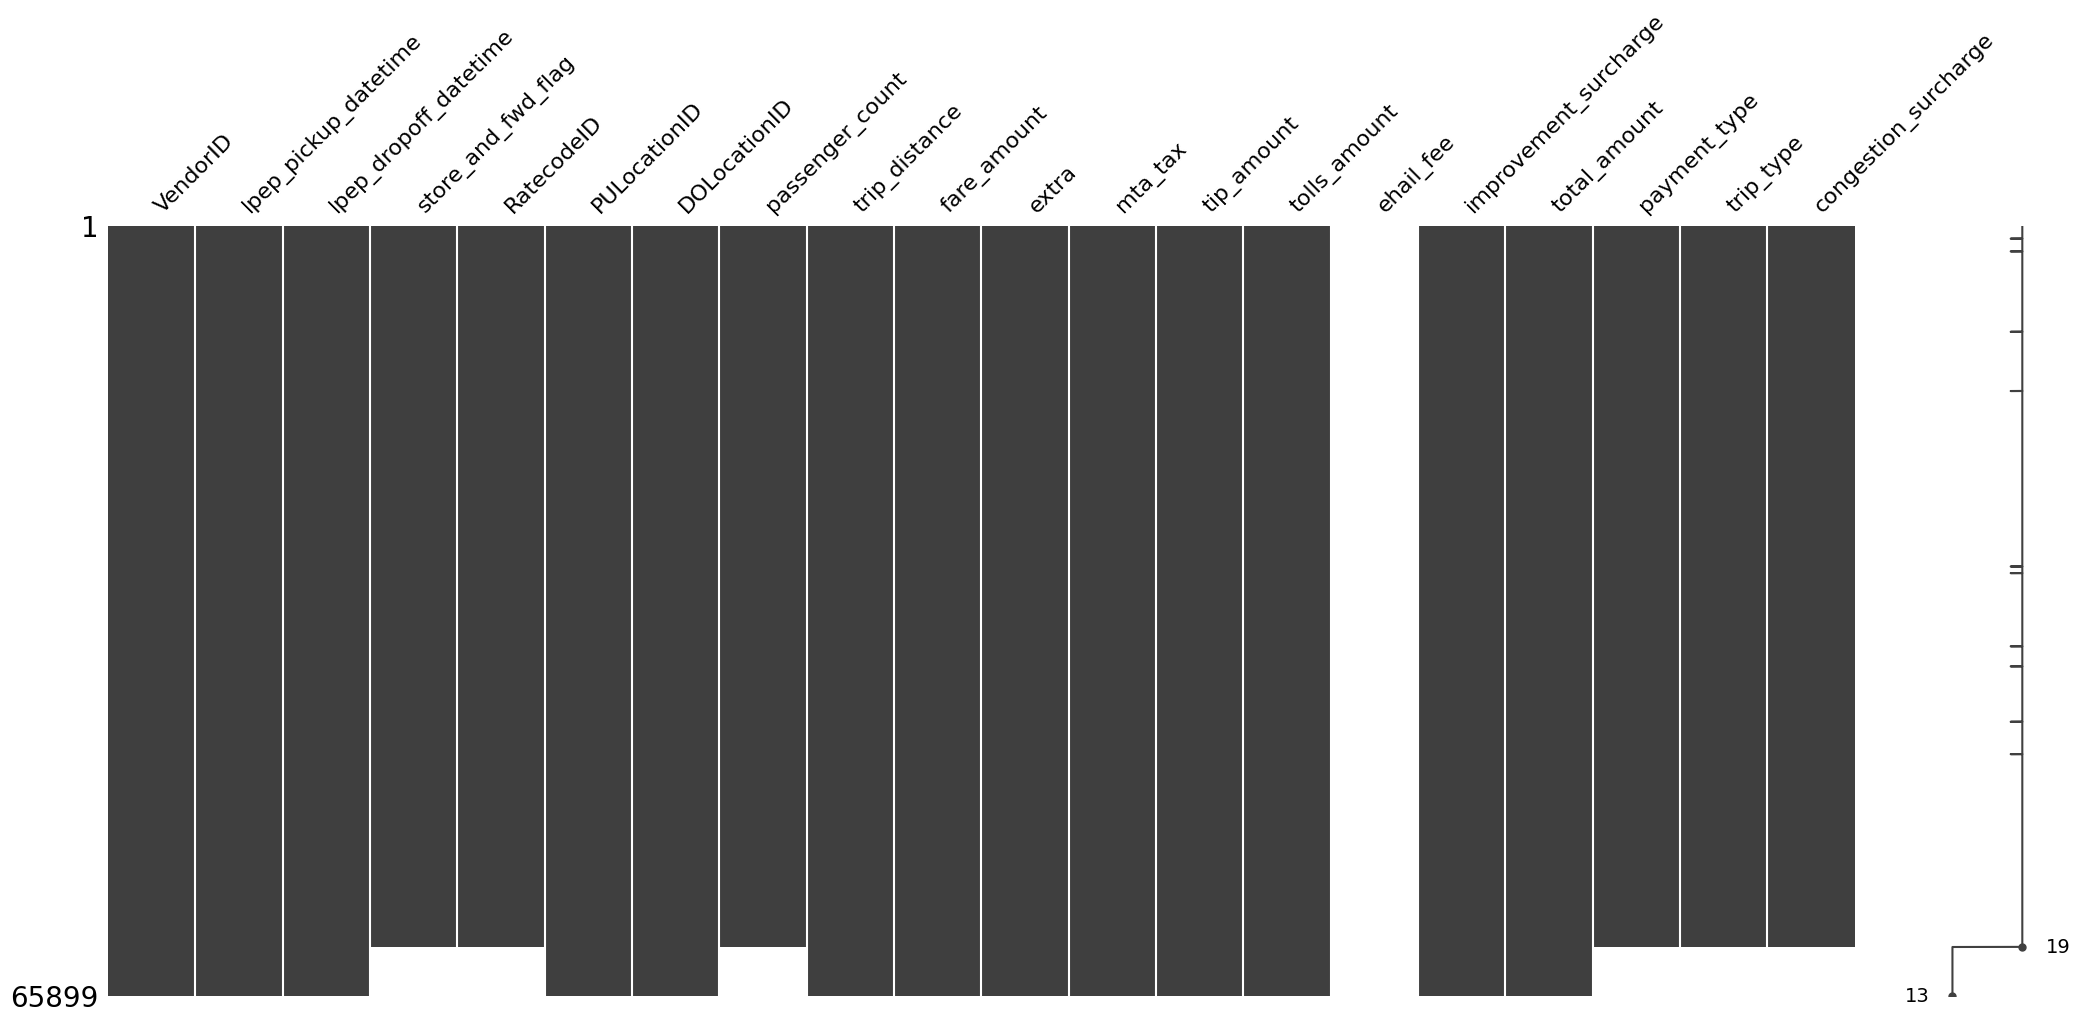

In [10]:
import missingno as mn

mn.matrix(df)

In [11]:
# persentase missing value di tiap kolom
df.isna().sum()/df.shape[0]*100

VendorID                   0.000000
lpep_pickup_datetime       0.000000
lpep_dropoff_datetime      0.000000
store_and_fwd_flag         6.365802
RatecodeID                 6.365802
PULocationID               0.000000
DOLocationID               0.000000
passenger_count            6.365802
trip_distance              0.000000
fare_amount                0.000000
extra                      0.000000
mta_tax                    0.000000
tip_amount                 0.000000
tolls_amount               0.000000
ehail_fee                100.000000
improvement_surcharge      0.000000
total_amount               0.000000
payment_type               6.365802
trip_type                  6.380977
congestion_surcharge       6.365802
dtype: float64

#### `ehail_fee`

Di kolom ini, data pada seluruh barisnya kosong sehingga dapat kita drop

In [12]:
#Drop kolom 'ehail_fee' karena seluruh datanya kosong
df.dropna(axis=1, how='all', inplace=True)
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

Dapat dilihat bahwa kolom `ehail_fee` telah dihapus

#### `store_and_fwd_flag`

Kolom ini berisikan bagaimana tabel berhasil dibuat apakah secara otomatis dari sistem atau disimpan terlebih dahulu dalam memori kendaraan, namun karena tidak akan mempengaruhi hasil analisa maka kolom ini dapat dihapus.

In [13]:
df.drop('store_and_fwd_flag', axis=1, inplace=True)
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'payment_type',
       'trip_type', 'congestion_surcharge'],
      dtype='object')

#### `RatecodeID`

In [14]:
df['RatecodeID'].unique()

array([ 1.,  5.,  4.,  3.,  2., 99., nan])

In [15]:
df['RatecodeID'].value_counts().sort_index(ascending=True)

RatecodeID
1.0     59978
2.0       150
3.0        29
4.0        56
5.0      1481
99.0       10
Name: count, dtype: int64

Pada kolom ini terdapat NaN dan value kategorik yang tidak sesuai dengan guideline, sehingga harus diubah nilai ordinalnya.

**Pertama** pada kasus ini, dapat dirumuskan hipotesis nol (H0) dan hipotesis alternatif (H1) sebagai berikut:

* **H0 (Hipotesis Nol)**: Tidak ada perbedaan yang signifikan antara tarif per-mile `RatecodeID` 99 dan 1, sehingga dapat diasumsikan bahwa `RatecodeID` 99 bisa diganti dengan 1.
* **H1 (Hipotesis Alternatif)**: Ada perbedaan yang signifikan antara tarif per-mile `RatecodeID` 99 dan 1, sehingga dapat diasusmsikan bahwa rate tarif per-mile sudah tidak standar dan `RatecodeID` 99 bisa diganti dengan 5 yang berarti rate-nya telah dinegosiasikan.

Untuk melakukannya kita akan melakukan T-Test Independence Double Population Mean dan kita mengasumsikan bahwa ***variance*** nya tidak sama.

In [16]:
# Memisahkan populasi data yang memiliki RatecodeID 99 dan 1
fare_99 = df[(df['RatecodeID'] == 99) & (df['trip_distance'] > 0)]['fare_amount'] / df[(df['RatecodeID'] == 99) & (df['trip_distance'] > 0)]['trip_distance']
fare_1 = df[(df['RatecodeID'] == 1) & (df['trip_distance'] > 0)]['fare_amount'] / df[(df['RatecodeID'] == 1) & (df['trip_distance'] > 0)]['trip_distance']

# T-Test Independen untuk tarif per-mile
t_statistic, p_value = ttest_ind(fare_99, fare_1, equal_var=False)

# Interpretasi hasil
alpha = 0.05
if p_value < alpha:
    print("Terdapat perbedaan yang signifikan antara RatecodeID 99 dan RatecodeID 1 dalam tarif per-mile.")
else:
    print("Tidak terdapat perbedaan yang signifikan antara RatecodeID 99 dan RatecodeID 1 dalam tarif per-mile.")

Tidak terdapat perbedaan yang signifikan antara RatecodeID 99 dan RatecodeID 1 dalam tarif per-mile.


Dapat kita lihat, bahwa `RatecodeID` yang memiliki value 99 dapat kita asumsikan sebagai 1 atau *Standard Fare* karena memiliki tarif per-mile standar.

In [17]:
# Merubah RatecodeID yang memiliki value 99.0 menjadi 1
df['RatecodeID'].replace({99.:1.}, inplace=True)

#Cek hasil replace
df.loc[(df['RatecodeID'] == 99)]

Empty DataFrame
Columns: [VendorID, lpep_pickup_datetime, lpep_dropoff_datetime, RatecodeID, PULocationID, DOLocationID, passenger_count, trip_distance, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, payment_type, trip_type, congestion_surcharge]
Index: []

Baris yang memiliki value ordinal 99 telah direplace dengan 1.

**Kedua** kita harus mereplace missing valuenya.

In [18]:
df['RatecodeID'].isna().sum()

4195

Dapat kita lihat, bahwa terdapat missing value sebanyak 4324 baris.

Selanjutnya, untuk rate code yang lain, berdasarkan guideline adalah kode tarif tertentu apabila penumpang turun atau naik di daerah tertentu. Untuk menghandle missing value dan mengkoreksi kesalahan data, kita harus melakukan cross-checking kepada tabel yang berisi ID dari lokasi taxi di New York

In [19]:
# Loading dataset berisi taxi zone di New York

loc_id = pd.read_csv('taxi_zones.csv')
loc_id

OBJECTID  Shape_Leng                                           the_geom  \
0           1    0.116357  MULTIPOLYGON (((-74.18445299999996 40.69499599...   
1           2    0.433470  MULTIPOLYGON (((-73.82337597260663 40.63898704...   
2           3    0.084341  MULTIPOLYGON (((-73.84792614099985 40.87134223...   
3           4    0.043567  MULTIPOLYGON (((-73.97177410965318 40.72582128...   
4           5    0.092146  MULTIPOLYGON (((-74.17421738099989 40.56256808...   
..        ...         ...                                                ...   
258       256    0.067915  MULTIPOLYGON (((-73.95834207500002 40.71330630...   
259       259    0.126750  MULTIPOLYGON (((-73.85107116191898 40.91037152...   
260       260    0.133514  MULTIPOLYGON (((-73.90175373399988 40.76077547...   
261       261    0.027120  MULTIPOLYGON (((-74.01332610899988 40.70503078...   
262       262    0.049064  MULTIPOLYGON (((-73.94383256699986 40.78285908...   

     Shape_Area                       zone  LocationID        borough  
0      0.000782             Newark Airport           1            EWR  
1      0.004866                Jamaica Bay           2         Queens  
2      0.000314    Allerton/Pelham Gardens           3          Bronx  
3      0.000112              Alphabet City           4      Manhattan  
4      0.000498              Arden Heights           5  Staten Island  
..          ...                        ...         ...            ...  
258    0.000169  Williamsburg (South Side)         256       Brooklyn  
259    0.000395         Woodlawn/Wakefield         259          Bronx  
260    0.000422                   Woodside         260         Queens  
261    0.000034         World Trade Center         261      Manhattan  
262    0.000122             Yorkville East         262      Manhattan  

[263 rows x 7 columns]

Untuk daerah yang memiliki tarif khusus adalah:

* JFK Airport
* Newark Airport
* Westchester or Nassau

In [20]:
loc_id.loc[loc_id['zone'].isin(['Newark Airport', 'JFK Airport', 'Westchester', 'Nassau'])]

OBJECTID  Shape_Leng                                           the_geom  \
0           1    0.116357  MULTIPOLYGON (((-74.18445299999996 40.69499599...   
136       132    0.245479  MULTIPOLYGON (((-73.8250346749999 40.663580133...   

     Shape_Area            zone  LocationID borough  
0      0.000782  Newark Airport           1     EWR  
136    0.002038     JFK Airport         132  Queens

Berdasarkan laman web https://www.nyc.gov/site/tlc/passengers/taxi-fare.page dan hasil cross-checking dengan dataset ID Lokasi, untuk `RatecodeID` yang valuenya missing harus diperhatikan beberapa kondisi berikut untuk menghandle datanya:

* Apabila kolom `fare_amount` memiliki value 70.0 serta kolom `PULocationID` atau `DOLocationID` memiliki value 132, maka `RatecodeID`-nya adalah **2** yang berarti rate taksi untuk menuju/dari *JFK Airport*
* Apabila kolom `PULocationID` atau`DOLocation` memiliki value 1, maka `RatecodeID`-nya adalah **3** yang berarti rate taksi untuk menuju/dari *Newark Airport*
* Dapat kita ketahui, untuk *Westchester or Nassau* tidak terdapat ID Lokasinya dalam dataset loc_id, namun nilai maksimal dari ID Lokasi pada dataset trip record berdasarkan data understanding adalah 265. Di sini dapat kita asumsikan, bahwa ID 264 dan 265 berlaku untuk daerah Westchester dan Nassau.

Selain itu kita juga berasumsi bahwa ada data yang tidak sesuai dengan kondisi tersebut walaupun sudah terisi, maka dari itu diperlukan penyesuaian.

In [21]:
# Mengisi missing value atau mengganti value pada kolom 'RatecodeID' sesuai dengan asumsi yang yang ditentukan

def cx_repl_rate(row):
    if row['fare_amount'] == 70 and (row['PULocationID'] == 132 or row['DOLocationID'] == 132):
        return 2
    elif row['PULocationID'] == 1 or row['DOLocationID'] == 1:
        return 3
    elif row['PULocationID'] in [264,265] or row['DOLocationID'] in [264, 265]:
        return 4
    elif row['RatecodeID'] == 5:
        return 5
    else:
       return 1 
df['RatecodeID'] = df.apply(lambda row: cx_repl_rate(row), axis=1)

# Mengubah bentuk kolom dari float menjadi integer
df['RatecodeID'] = df['RatecodeID'].astype('int64')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65899 entries, 0 to 68081
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               65899 non-null  int64         
 1   lpep_pickup_datetime   65899 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  65899 non-null  datetime64[ns]
 3   RatecodeID             65899 non-null  int64         
 4   PULocationID           65899 non-null  int64         
 5   DOLocationID           65899 non-null  int64         
 6   passenger_count        61704 non-null  float64       
 7   trip_distance          65899 non-null  float64       
 8   fare_amount            65899 non-null  float64       
 9   extra                  65899 non-null  float64       
 10  mta_tax                65899 non-null  float64       
 11  tip_amount             65899 non-null  float64       
 12  tolls_amount           65899 non-null  float64       
 13  improv

In [23]:
df['RatecodeID'].isna().sum()

0

In [24]:
df['RatecodeID'].value_counts().sort_index(ascending=True)

RatecodeID
1    63863
2       96
3       25
4      694
5     1221
Name: count, dtype: int64

Dapat kita lihat bahwa data telah dihandle dan memiliki value kategorikal yang sesuai guideline untuk dilakukan analisa nantinya.

#### `passenger_count`

In [25]:
df['passenger_count'].unique()

array([ 1.,  2.,  4.,  3.,  6.,  5.,  0.,  7.,  9.,  8., nan])

In [26]:
# Menghitung jumlah dari masing-masing value pada kolom 'passenger_count'
df['passenger_count'].value_counts().sort_index(ascending=True)

passenger_count
0.0      322
1.0    52423
2.0     4940
3.0      933
4.0      346
5.0     1712
6.0     1020
7.0        4
8.0        2
9.0        2
Name: count, dtype: int64

In [27]:
# Menghitung jumlah missing value pada kolom 'passenger_count'
df['passenger_count'].isna().sum()

4195

Pada kolom `passenger_count` terdapat value yang tidak mungkin terjadi.

* Jumlah penumpang 0, kemungkinan terjadi kesalahan input pada driver, mengingat angka 0 dan 1 berdekatan
* Jumlah penumpang lebih dari 6, mengingat kapasitas mobil Minivan adalah 7 orang termasuk supir.

Sehingga dapat kita simpulkan bahwa:

* Pada value 0 dan NaN dapat kita asumsikan penumpang taxinya 1 orang.
* Pada value 7, 8, 9 dapat kita ubah ke 6 orang.

In [28]:
# Mengganti 0 dan NaN menjadi 1 dan lebih dari 6 menjadi 6
df['passenger_count'] = df['passenger_count'].fillna(1).apply(lambda x: 1 if x == 0 else x).apply(lambda x: 6 if x > 6 else x)

# Merubah bentuk float menjadi integer
df['passenger_count'] = df['passenger_count'].astype('int64')

In [29]:
df['passenger_count'].value_counts().sort_index(ascending=True)

passenger_count
1    56940
2     4940
3      933
4      346
5     1712
6     1028
Name: count, dtype: int64

Dapat kita lihat, bahwa missing value dan data yang tidak normal sudah kita handle. Dan sudah siap untuk dianalisa

#### `payment_type`

In [30]:
df['payment_type'].unique()

array([ 1.,  2.,  3.,  4.,  5., nan])

In [31]:
df[df['payment_type'].isna()]

VendorID lpep_pickup_datetime lpep_dropoff_datetime  RatecodeID  \
63887         2  2023-01-01 00:28:00   2023-01-01 00:54:00           1   
63888         2  2023-01-01 00:39:00   2023-01-01 00:52:00           1   
63889         2  2023-01-01 00:58:00   2023-01-01 01:21:00           1   
63890         2  2023-01-01 00:35:00   2023-01-01 00:55:00           1   
63891         2  2023-01-01 00:45:00   2023-01-01 00:55:00           1   
...         ...                  ...                   ...         ...   
68077         2  2023-01-30 21:54:00   2023-01-30 22:04:00           1   
68078         2  2023-01-30 21:34:00   2023-01-30 21:46:00           1   
68079         2  2023-01-30 21:56:00   2023-01-30 22:09:00           1   
68080         2  2023-01-30 22:36:00   2023-01-30 23:01:00           1   
68081         2  2023-01-30 22:25:00   2023-01-30 22:38:00           1   

       PULocationID  DOLocationID  passenger_count  trip_distance  \
63887             7            17                1           9.33   
63888            37            37                1           2.67   
63889            80             7                1           7.39   
63890           169            42                1           4.04   
63891            42           262                1           3.86   
...             ...           ...              ...            ...   
68077             7           229                1           3.08   
68078            42           239                1           3.05   
68079           244            42                1           2.26   
68080            33           100                1           5.12   
68081           146           226                1           1.73   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
63887        36.03    0.0      0.0        7.41           0.0   
63888        14.55    0.0      0.0        3.11           0.0   
63889        32.13    0.0      0.0        6.63           0.0   
63890        17.85    0.0      0.0        0.00           0.0   
63891        19.67    0.0      0.0        4.68           0.0   
...            ...    ...      ...         ...           ...   
68077        14.91    0.0      0.0        1.87           0.0   
68078        15.19    0.0      0.0        3.79           0.0   
68079        14.65    0.0      0.0        3.13           0.0   
68080        20.08    0.0      0.0        2.00           0.0   
68081        14.58    0.0      0.0        3.12           0.0   

       improvement_surcharge  total_amount  payment_type  trip_type  \
63887                    1.0         44.44           NaN        NaN   
63888                    1.0         18.66           NaN        NaN   
63889                    1.0         39.76           NaN        NaN   
63890                    1.0         18.85           NaN        NaN   
63891                    1.0         28.10           NaN        NaN   
...                      ...           ...           ...        ...   
68077                    1.0         20.53           NaN        NaN   
68078                    1.0         22.73           NaN        NaN   
68079                    1.0         18.78           NaN        NaN   
68080                    1.0         25.83           NaN        NaN   
68081                    1.0         18.70           NaN        NaN   

       congestion_surcharge  
63887                   NaN  
63888                   NaN  
63889                   NaN  
63890                   NaN  
63891                   NaN  
...                     ...  
68077                   NaN  
68078                   NaN  
68079                   NaN  
68080                   NaN  
68081                   NaN  

[4195 rows x 18 columns]

Berdasarkan guideline, pada kolom ini seharusnya diisi oleh angka 1 sampai 6. Namun dari syntax di atas, hanya terdapat 5 value. Value ke-6 yang berarti *Travel Voided* (Perjalanan dibatalkan) tidak ada. Namun sebelum mengganti missing value kita harus melihat kondisinya.

* Di sini kita bisa melihat apabila pembayaran menggunakan *Credit Card*, penumpang dapat memberikan tip yang terekam di sistem dan disimpan dalam kolom `tip_amount`, maka kolom `payment_type` seharusnya berisi angka 1
* Apabila kolom `tip_amount` kosong, maka `payment_type` dapat dimasukkan angka 5 yang memiliki arti *Unknown*
* Apabila kolom `trip_distance` bernilai 0, dan selisih waktu antara argo meter dinyalakan dan dimatikan kurang dari 2 menit, maka dapat disimpulkan perjalanan dibatalkan dan dapat dimasukkan angka 6 yang berarti *Voided Trip*

Selain itu kita juga berasumsi bahwa ada data yang tidak sesuai dengan kondisi tersebut walaupun sudah terisi, maka dari itu diperlukan penyesuaian.

In [32]:
df['payment_type'].value_counts().sort_index(ascending=True)

payment_type
1.0    39272
2.0    21883
3.0      457
4.0       90
5.0        2
Name: count, dtype: int64

In [33]:
# Mengisi missing value (NaN) dan mengganti value yang sudah ada sesuai asumsi yang yang ditentukan
def cx_repl_paytype(row):
    if row['tip_amount'] > 0 and pd.isna(row['payment_type']):
        return 1
    elif row['payment_type'] == 2:
        return 2
    elif row['payment_type'] == 3:
        return 3
    elif row['payment_type'] == 4:
        return 4
    elif row['tip_amount'] == 0 and pd.isna(row['payment_type']):
        return 5
    elif row['trip_distance'] == 0 and (row['lpep_dropoff_datetime'] - row['lpep_pickup_datetime'] < pd.Timedelta(seconds=113)):
        return 6
    else:
        return row['payment_type']
        
df['payment_type'] = df.apply(lambda row: cx_repl_paytype(row), axis=1)

# Mengubah bentuk kolom dari float menjadi integer
df['payment_type'] = df['payment_type'].astype('int64')
df

VendorID lpep_pickup_datetime lpep_dropoff_datetime  RatecodeID  \
0             2  2023-01-01 00:26:10   2023-01-01 00:37:11           1   
1             2  2023-01-01 00:51:03   2023-01-01 00:57:49           1   
2             2  2023-01-01 00:35:12   2023-01-01 00:41:32           1   
3             1  2023-01-01 00:13:14   2023-01-01 00:19:03           1   
4             1  2023-01-01 00:33:04   2023-01-01 00:39:02           1   
...         ...                  ...                   ...         ...   
68077         2  2023-01-30 21:54:00   2023-01-30 22:04:00           1   
68078         2  2023-01-30 21:34:00   2023-01-30 21:46:00           1   
68079         2  2023-01-30 21:56:00   2023-01-30 22:09:00           1   
68080         2  2023-01-30 22:36:00   2023-01-30 23:01:00           1   
68081         2  2023-01-30 22:25:00   2023-01-30 22:38:00           1   

       PULocationID  DOLocationID  passenger_count  trip_distance  \
0               166           143                1           2.58   
1                24            43                1           1.81   
2               223           179                1           0.00   
3                41           238                1           1.30   
4                41            74                1           1.10   
...             ...           ...              ...            ...   
68077             7           229                1           3.08   
68078            42           239                1           3.05   
68079           244            42                1           2.26   
68080            33           100                1           5.12   
68081           146           226                1           1.73   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0            14.90    1.0      0.5        4.03           0.0   
1            10.70    1.0      0.5        2.64           0.0   
2             7.20    1.0      0.5        1.94           0.0   
3             6.50    0.5      1.5        1.70           0.0   
4             6.00    0.5      1.5        0.00           0.0   
...            ...    ...      ...         ...           ...   
68077        14.91    0.0      0.0        1.87           0.0   
68078        15.19    0.0      0.0        3.79           0.0   
68079        14.65    0.0      0.0        3.13           0.0   
68080        20.08    0.0      0.0        2.00           0.0   
68081        14.58    0.0      0.0        3.12           0.0   

       improvement_surcharge  total_amount  payment_type  trip_type  \
0                        1.0         24.18             1        1.0   
1                        1.0         15.84             1        1.0   
2                        1.0         11.64             1        1.0   
3                        1.0         10.20             1        1.0   
4                        1.0          8.00             1        1.0   
...                      ...           ...           ...        ...   
68077                    1.0         20.53             1        NaN   
68078                    1.0         22.73             1        NaN   
68079                    1.0         18.78             1        NaN   
68080                    1.0         25.83             1        NaN   
68081                    1.0         18.70             1        NaN   

       congestion_surcharge  
0                      2.75  
1                      0.00  
2                      0.00  
3                      0.00  
4                      0.00  
...                     ...  
68077                   NaN  
68078                   NaN  
68079                   NaN  
68080                   NaN  
68081                   NaN  

[65899 rows x 18 columns]

In [34]:
df['payment_type'].value_counts().sort_index(ascending=True)

payment_type
1    42371
2    21883
3      457
4       90
5      483
6      615
Name: count, dtype: int64

In [35]:
df['payment_type'].isna().sum()

0

Dapat dilihat, kita telah menghandle missing value. Namun, menurut saya voided trip lebih baik dihapus karena tidak akan masuk ke analisa saya dan berpotensi mengacaukan nilai analisa.

In [36]:
# Menghapus baris data yang memiliki kode payment type 6
df = df.drop(df[df['payment_type']==6].index)
df = df.reset_index(drop=True) # Reset index dataset
df


VendorID lpep_pickup_datetime lpep_dropoff_datetime  RatecodeID  \
0             2  2023-01-01 00:26:10   2023-01-01 00:37:11           1   
1             2  2023-01-01 00:51:03   2023-01-01 00:57:49           1   
2             2  2023-01-01 00:35:12   2023-01-01 00:41:32           1   
3             1  2023-01-01 00:13:14   2023-01-01 00:19:03           1   
4             1  2023-01-01 00:33:04   2023-01-01 00:39:02           1   
...         ...                  ...                   ...         ...   
65279         2  2023-01-30 21:54:00   2023-01-30 22:04:00           1   
65280         2  2023-01-30 21:34:00   2023-01-30 21:46:00           1   
65281         2  2023-01-30 21:56:00   2023-01-30 22:09:00           1   
65282         2  2023-01-30 22:36:00   2023-01-30 23:01:00           1   
65283         2  2023-01-30 22:25:00   2023-01-30 22:38:00           1   

       PULocationID  DOLocationID  passenger_count  trip_distance  \
0               166           143                1           2.58   
1                24            43                1           1.81   
2               223           179                1           0.00   
3                41           238                1           1.30   
4                41            74                1           1.10   
...             ...           ...              ...            ...   
65279             7           229                1           3.08   
65280            42           239                1           3.05   
65281           244            42                1           2.26   
65282            33           100                1           5.12   
65283           146           226                1           1.73   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0            14.90    1.0      0.5        4.03           0.0   
1            10.70    1.0      0.5        2.64           0.0   
2             7.20    1.0      0.5        1.94           0.0   
3             6.50    0.5      1.5        1.70           0.0   
4             6.00    0.5      1.5        0.00           0.0   
...            ...    ...      ...         ...           ...   
65279        14.91    0.0      0.0        1.87           0.0   
65280        15.19    0.0      0.0        3.79           0.0   
65281        14.65    0.0      0.0        3.13           0.0   
65282        20.08    0.0      0.0        2.00           0.0   
65283        14.58    0.0      0.0        3.12           0.0   

       improvement_surcharge  total_amount  payment_type  trip_type  \
0                        1.0         24.18             1        1.0   
1                        1.0         15.84             1        1.0   
2                        1.0         11.64             1        1.0   
3                        1.0         10.20             1        1.0   
4                        1.0          8.00             1        1.0   
...                      ...           ...           ...        ...   
65279                    1.0         20.53             1        NaN   
65280                    1.0         22.73             1        NaN   
65281                    1.0         18.78             1        NaN   
65282                    1.0         25.83             1        NaN   
65283                    1.0         18.70             1        NaN   

       congestion_surcharge  
0                      2.75  
1                      0.00  
2                      0.00  
3                      0.00  
4                      0.00  
...                     ...  
65279                   NaN  
65280                   NaN  
65281                   NaN  
65282                   NaN  
65283                   NaN  

[65284 rows x 18 columns]

In [37]:
df['payment_type'].value_counts().sort_index(ascending=True)

payment_type
1    42371
2    21883
3      457
4       90
5      483
Name: count, dtype: int64

#### `trip_type`

In [38]:
df['trip_type'].unique()

array([ 1.,  2., nan])

In [39]:
# Menghitung jumlah dari masing-masing value pada kolom 'trip_type'
df['trip_type'].value_counts().sort_index(ascending=True)

trip_type
1.0    60177
2.0      902
Name: count, dtype: int64

In [40]:
# Menghitung jumlah missing value pada kolom 'trip_type'
df['trip_type'].isna().sum()

4205

Untuk kondisi ini, saya mengasumsikan bahwa driver tidak menginput jenis perjalanan saat mengambil penumpang, maka dari itu saya akan mengisi missing value dengan 1 atau *Street-hail*

In [41]:
# Mengisi missing value

df['trip_type'].fillna(1, inplace=True)

In [42]:
# Cek ulang
df['trip_type'].isna().sum()

0

#### `congestion_surcharge`

In [43]:
# Mengecek sebaran data pada kolom 'congestion surcharge'
df['congestion_surcharge'].value_counts().sort_index(ascending=True)

congestion_surcharge
-2.75        3
 0.00    44753
 2.50       16
 2.75    16317
Name: count, dtype: int64

In [44]:
# Mengecek jumlah missing value
df['congestion_surcharge'].isna().sum()

4195

In [45]:
# Cek persentase

(df['congestion_surcharge'].isna().sum()/df.shape[0])*100

6.425770479750015

Dalam kasus ini, berdasarkan website https://www.tax.ny.gov/bus/cs/csidx.htm#taxis *congestion surcharge* berlaku apabila kendaraan melewati:

* Memulai dan mengakhiri perjalanan di New York State, dan
* Memulai, mengakhiri, atau melewati Manhattan, bagian selatan dari dan terkecuali 96th Street (an area known as the congestion zone)

![Congestion Zone in New York](https://www.nyc.gov/assets/tlc/images/content/pages/about/congestion-pricing.png)

Untuk dalam menghandle missing value, saya berasumsi bahwa taxi memang tidak melewati Congestion Zone, maka dapat kita isi dengan angka 0

In [46]:
# Mengisi missing value

df['congestion_surcharge'].fillna(0, inplace=True)

In [47]:
# Mengecek jumlah missing value

df['congestion_surcharge'].isna().sum()

0

Dapat kita lihat bahwa kita telah berhasil menghapus missing value atau mengisinya dengan value yang kita tentukan. Untuk lebih baiknya, kita melakukan pengecekan ulang kepada seluruh data set.

In [48]:
df.isna().sum().sort_values(ascending=False)

VendorID                 0
lpep_pickup_datetime     0
trip_type                0
payment_type             0
total_amount             0
improvement_surcharge    0
tolls_amount             0
tip_amount               0
mta_tax                  0
extra                    0
fare_amount              0
trip_distance            0
passenger_count          0
DOLocationID             0
PULocationID             0
RatecodeID               0
lpep_dropoff_datetime    0
congestion_surcharge     0
dtype: int64

Kita sudah bisa melihat bahwa sudah tidak ada lagi missing value, namun perlu diingat, bahwa saat kita men-describe data set ada value negatif yang perlu kita tinjau lebih lanjut.

### Mengecek Nilai Negatif Pada Data

Di sini, kita akan mengecek ada berapa saja value yang bernilai negatif dan mengecek bahwa nilai negatif tersebut memang harusnya seperti itu (nilai yang sah), atau terjadi error pada input data.

In [49]:
content = []
numerical_columns = df.select_dtypes(include=['number']).columns

for i in numerical_columns:
    num_negative = df[df[i] < 0][i].unique()  # Memanggil value negatif
    counter = (df[i] < 0).sum() # Menghitung jumlah value negatif
    content.append([i, counter, num_negative])

infotabel = pd.DataFrame(columns=['Column Name', 'Value Count', 'Negative Values'], data=content)
infotabel

Column Name  Value Count  \
0                VendorID            0   
1              RatecodeID            0   
2            PULocationID            0   
3            DOLocationID            0   
4         passenger_count            0   
5           trip_distance            0   
6             fare_amount          169   
7                   extra           74   
8                 mta_tax          159   
9              tip_amount            9   
10           tolls_amount            0   
11  improvement_surcharge          167   
12           total_amount          172   
13           payment_type            0   
14              trip_type            0   
15   congestion_surcharge            3   

                                      Negative Values  
0                                                  []  
1                                                  []  
2                                                  []  
3                                                  []  
4                                                  []  
5                                                  []  
6   [-3.0, -8.6, -4.5, -3.7, -4.4, -10.0, -7.2, -2...  
7                                  [-1.0, -2.5, -0.5]  
8                                              [-0.5]  
9                         [-0.9, -0.01, -0.13, -10.5]  
10                                                 []  
11                                       [-1.0, -0.3]  
12  [-4.5, -11.1, -5.3, -5.2, -5.4, -5.9, -11.5, -...  
13                                                 []  
14                                                 []  
15                                            [-2.75]

Dapat kita lihat dari tabel di atas, bahwa nilai negatif tidak seharusnya terjadi. Karena pada hakikatnya kolom `fare_amount`, `extra`, `mta_tax`, `tip_amount`, `improvement_surcharge` dan `congestion_surcharge` seharusnya bernilai positif karena nilai tersebut akan dibebankan kepada penumpang.

Oleh karena itu, dapat disimpulkan bahwa aman untuk mengganti seluruh nilai negatif yang terdapat pada data kita.

In [50]:
# merubah nilai negatif menjadi nilai positif pada seluruh data
df2 = df.copy()
numcol = df2.select_dtypes(include=['number'])
df2[numcol.columns] = numcol.abs()
df.update(df2)
df

VendorID lpep_pickup_datetime lpep_dropoff_datetime  RatecodeID  \
0             2  2023-01-01 00:26:10   2023-01-01 00:37:11           1   
1             2  2023-01-01 00:51:03   2023-01-01 00:57:49           1   
2             2  2023-01-01 00:35:12   2023-01-01 00:41:32           1   
3             1  2023-01-01 00:13:14   2023-01-01 00:19:03           1   
4             1  2023-01-01 00:33:04   2023-01-01 00:39:02           1   
...         ...                  ...                   ...         ...   
65279         2  2023-01-30 21:54:00   2023-01-30 22:04:00           1   
65280         2  2023-01-30 21:34:00   2023-01-30 21:46:00           1   
65281         2  2023-01-30 21:56:00   2023-01-30 22:09:00           1   
65282         2  2023-01-30 22:36:00   2023-01-30 23:01:00           1   
65283         2  2023-01-30 22:25:00   2023-01-30 22:38:00           1   

       PULocationID  DOLocationID  passenger_count  trip_distance  \
0               166           143                1           2.58   
1                24            43                1           1.81   
2               223           179                1           0.00   
3                41           238                1           1.30   
4                41            74                1           1.10   
...             ...           ...              ...            ...   
65279             7           229                1           3.08   
65280            42           239                1           3.05   
65281           244            42                1           2.26   
65282            33           100                1           5.12   
65283           146           226                1           1.73   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0            14.90    1.0      0.5        4.03           0.0   
1            10.70    1.0      0.5        2.64           0.0   
2             7.20    1.0      0.5        1.94           0.0   
3             6.50    0.5      1.5        1.70           0.0   
4             6.00    0.5      1.5        0.00           0.0   
...            ...    ...      ...         ...           ...   
65279        14.91    0.0      0.0        1.87           0.0   
65280        15.19    0.0      0.0        3.79           0.0   
65281        14.65    0.0      0.0        3.13           0.0   
65282        20.08    0.0      0.0        2.00           0.0   
65283        14.58    0.0      0.0        3.12           0.0   

       improvement_surcharge  total_amount  payment_type  trip_type  \
0                        1.0         24.18             1        1.0   
1                        1.0         15.84             1        1.0   
2                        1.0         11.64             1        1.0   
3                        1.0         10.20             1        1.0   
4                        1.0          8.00             1        1.0   
...                      ...           ...           ...        ...   
65279                    1.0         20.53             1        1.0   
65280                    1.0         22.73             1        1.0   
65281                    1.0         18.78             1        1.0   
65282                    1.0         25.83             1        1.0   
65283                    1.0         18.70             1        1.0   

       congestion_surcharge  
0                      2.75  
1                      0.00  
2                      0.00  
3                      0.00  
4                      0.00  
...                     ...  
65279                  0.00  
65280                  0.00  
65281                  0.00  
65282                  0.00  
65283                  0.00  

[65284 rows x 18 columns]

In [51]:
# Cek ulang data bernilai negatif
content = []
numerical_columns = df.select_dtypes(include=['number']).columns

for i in numerical_columns:
    num_negative = df[df[i] < 0][i].unique()  # Memanggil value negatif
    counter = (df[i] < 0).sum() # Menghitung jumlah value negatif
    content.append([i, counter, num_negative])

infotabel = pd.DataFrame(columns=['Column Name', 'Value Count', 'Negative Values'], data=content)
infotabel

Column Name  Value Count Negative Values
0                VendorID            0              []
1              RatecodeID            0              []
2            PULocationID            0              []
3            DOLocationID            0              []
4         passenger_count            0              []
5           trip_distance            0              []
6             fare_amount            0              []
7                   extra            0              []
8                 mta_tax            0              []
9              tip_amount            0              []
10           tolls_amount            0              []
11  improvement_surcharge            0              []
12           total_amount            0              []
13           payment_type            0              []
14              trip_type            0              []
15   congestion_surcharge            0              []

### Mengecek dan Handling Outliers Pada Data

Dapat kita lihat pada Data Understanding, bahwa diduga terdapat outliers pada kolom `trip_distance`, `fare_amount`, `extra`, `mta_tax`, `tip_amount`, dan `tolls_amount`

Untuk mengeceknya kita dapat melihat sebaran datanya menggunakan scatter plot

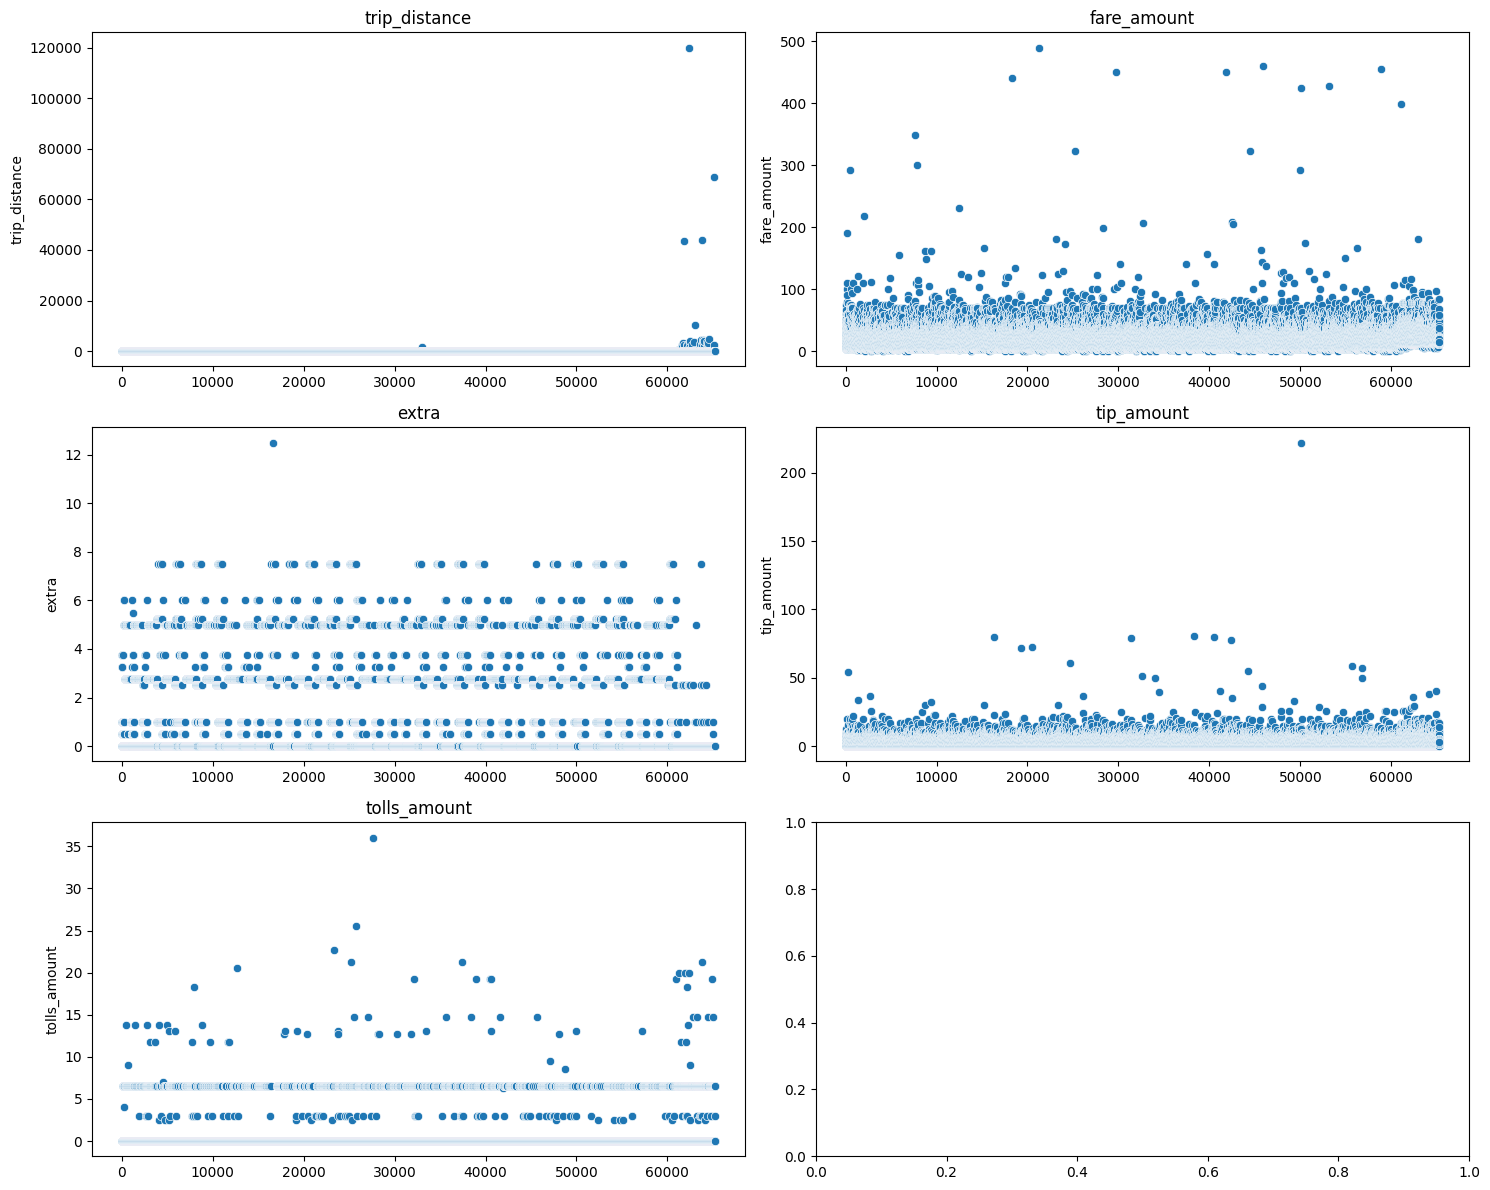

In [52]:
# Memilih kolom yang diduga terdapat outliers
df_out = df[['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount']]

# Menampilkan scatter plot
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()
for i, kolom in enumerate(df_out.columns):
    sns.scatterplot(data=df_out, x=df_out.index, y=kolom, ax=axes[i])
    axes[i].set_title(f'{kolom}')
plt.tight_layout()
plt.show()

In [53]:
# Membuat fungsi mendeteksi Outliers
def handle_outliers(column, df_out_column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Mendeteksi outliers
    outliers = (column < lower_bound) | (column > upper_bound)
    
    # Mengganti outliers dengan nilai yang sesuai dari df_out
    median = df_out_column.median()
    column[outliers] = median
    
    return column

# Mendeteksi dan mengatasi outliers pada setiap kolom
for col in df_out.columns:
    df[col] = handle_outliers(df[col], df_out[col])
df

VendorID lpep_pickup_datetime lpep_dropoff_datetime  RatecodeID  \
0             2  2023-01-01 00:26:10   2023-01-01 00:37:11           1   
1             2  2023-01-01 00:51:03   2023-01-01 00:57:49           1   
2             2  2023-01-01 00:35:12   2023-01-01 00:41:32           1   
3             1  2023-01-01 00:13:14   2023-01-01 00:19:03           1   
4             1  2023-01-01 00:33:04   2023-01-01 00:39:02           1   
...         ...                  ...                   ...         ...   
65279         2  2023-01-30 21:54:00   2023-01-30 22:04:00           1   
65280         2  2023-01-30 21:34:00   2023-01-30 21:46:00           1   
65281         2  2023-01-30 21:56:00   2023-01-30 22:09:00           1   
65282         2  2023-01-30 22:36:00   2023-01-30 23:01:00           1   
65283         2  2023-01-30 22:25:00   2023-01-30 22:38:00           1   

       PULocationID  DOLocationID  passenger_count  trip_distance  \
0               166           143                1           2.58   
1                24            43                1           1.81   
2               223           179                1           0.00   
3                41           238                1           1.30   
4                41            74                1           1.10   
...             ...           ...              ...            ...   
65279             7           229                1           3.08   
65280            42           239                1           3.05   
65281           244            42                1           2.26   
65282            33           100                1           5.12   
65283           146           226                1           1.73   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0            14.90    1.0      0.5        4.03           0.0   
1            10.70    1.0      0.5        2.64           0.0   
2             7.20    1.0      0.5        1.94           0.0   
3             6.50    0.5      1.5        1.70           0.0   
4             6.00    0.5      1.5        0.00           0.0   
...            ...    ...      ...         ...           ...   
65279        14.91    0.0      0.0        1.87           0.0   
65280        15.19    0.0      0.0        3.79           0.0   
65281        14.65    0.0      0.0        3.13           0.0   
65282        20.08    0.0      0.0        2.00           0.0   
65283        14.58    0.0      0.0        3.12           0.0   

       improvement_surcharge  total_amount  payment_type  trip_type  \
0                        1.0         24.18             1        1.0   
1                        1.0         15.84             1        1.0   
2                        1.0         11.64             1        1.0   
3                        1.0         10.20             1        1.0   
4                        1.0          8.00             1        1.0   
...                      ...           ...           ...        ...   
65279                    1.0         20.53             1        1.0   
65280                    1.0         22.73             1        1.0   
65281                    1.0         18.78             1        1.0   
65282                    1.0         25.83             1        1.0   
65283                    1.0         18.70             1        1.0   

       congestion_surcharge  
0                      2.75  
1                      0.00  
2                      0.00  
3                      0.00  
4                      0.00  
...                     ...  
65279                  0.00  
65280                  0.00  
65281                  0.00  
65282                  0.00  
65283                  0.00  

[65284 rows x 18 columns]

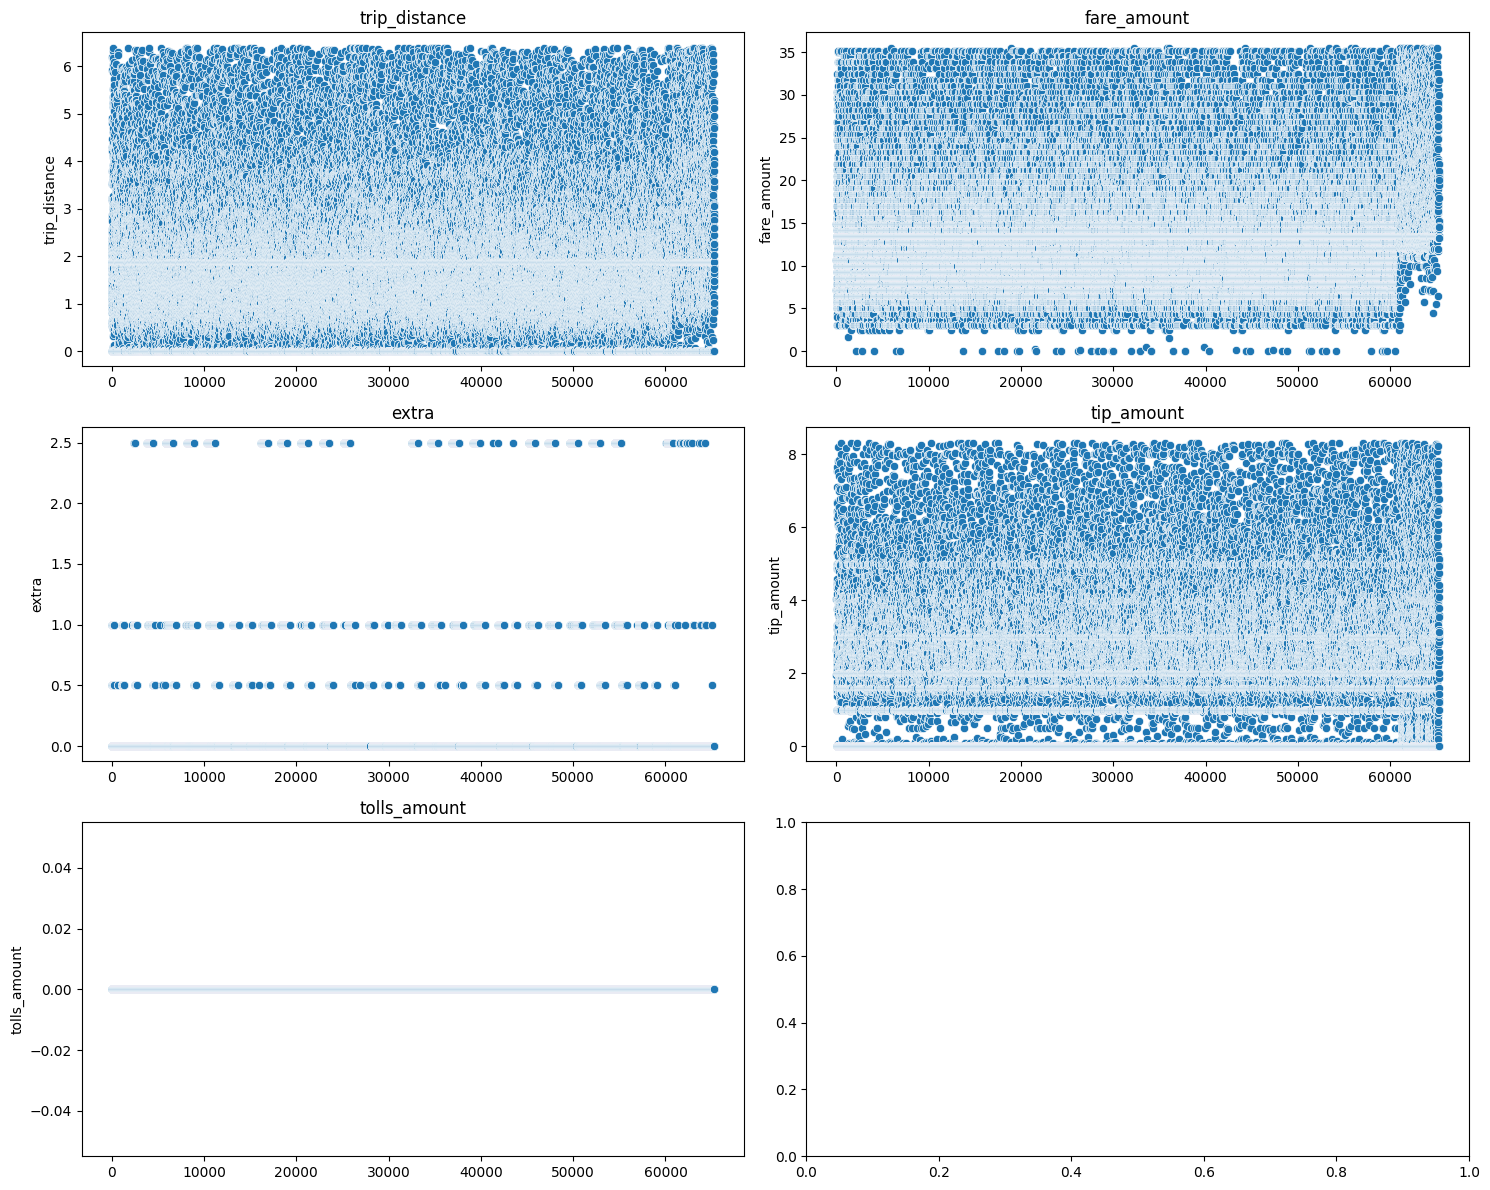

In [54]:
# Melihat apakah outliers telah terhandle

df_out2 = df[['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount']]
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()
for i, kolom in enumerate(df_out2.columns):
    sns.scatterplot(data=df_out2, x=df_out2.index, y=kolom, ax=axes[i])
    axes[i].set_title(f'{kolom}')
plt.tight_layout()
plt.show()

Berdasarkan scatter plot yang terbaru, kita telah menghandle outliers dengan sukses. Maka, data telah siap kita analisa.

# Data Analysis, Visualisasi dan Rekomendasi

## 1. Analisa karakteristik penggunaan taksi berdasarkan jumlah penumpang per-trip

### Total Keseluruhan Bulanan

In [55]:
# Membuat dataframe yang berisikan jumlah penumpang
df2 = pd.DataFrame(df.groupby(df['passenger_count']).size().reset_index(name='Total'))
df2

passenger_count  Total
0                1  56408
1                2   4884
2                3    918
3                4    345
4                5   1706
5                6   1023

In [56]:
df2['percentage'] = (df2['Total']/df2['Total'].sum()*100).apply(lambda x: float(x))
df2

passenger_count  Total  percentage
0                1  56408   86.404019
1                2   4884    7.481159
2                3    918    1.406164
3                4    345    0.528460
4                5   1706    2.613198
5                6   1023    1.567000

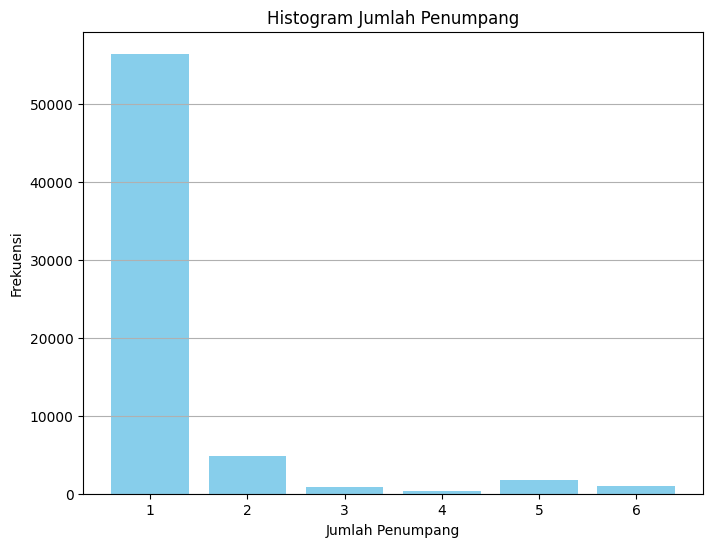

In [57]:
jumlah_penumpang = df2['passenger_count']
frekuensi = df2['Total']

# Membuat histogram
plt.figure(figsize=(8, 6))
plt.bar(jumlah_penumpang, frekuensi, color='skyblue')
plt.title('Histogram Jumlah Penumpang')
plt.xlabel('Jumlah Penumpang')
plt.ylabel('Frekuensi')
plt.grid(axis='y')
plt.xticks(jumlah_penumpang)
plt.show()

Dari histogram di atas, dapat kita ketahui bahwa penggunaan taksi masih di dominasi oleh penggunaan perorangan, yaitu sebesar 86,43% dari frekuensi perjalanan taksi di New York City pada Bulan Januari 2023. 

Telah kita ketahui juga, bahwa taksi di New York City terbagi menjadi dua tipe, yaitu Sedan dan Minivan. Disini kita akan menguji, apakah terdapat perbedaan tarif per-mile yang signifikan antara tarif taksi sedan dengan tarif taksi minivan untuk memaksimalkan pendapatan. Kita akan melakukan T-Test dari untuk mencari signifikansi rata-rata tarif untuk kategori mobil sedan dan minivan.

* Ho = Terdapat perbedaan yang signifikan antara taksi sedan dan minivan
* H1 = Tidak terdapat perbedaan yang signifikan antara taksi sedan dan minivan

In [58]:
# Memisahkan data antara taxi sedan (1-4 penumpang) dan taxi minivan (lebih dari 4 penumpang) untuk fare amount dan trip distance
fare_sedan = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 4)]['fare_amount'] / df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 4)]['trip_distance']
fare_minivan = df[(df['passenger_count'] > 4)]['fare_amount'] / df[(df['passenger_count'] > 4)]['trip_distance']

# T-Test Independent untuk tarif per-mile
t_statistic, p_value = ttest_ind(fare_sedan, fare_minivan, equal_var=False)

# Interpretasi hasil
alpha = 0.05
if p_value < alpha:
    print("Terdapat perbedaan yang signifikan antara taxi sedan dan taxi minivan dalam tarif per-mile.")
else:
    print("Tidak terdapat perbedaan yang signifikan antara taxi sedan dan taxi minivan dalam tarif per-mile.")

Tidak terdapat perbedaan yang signifikan antara taxi sedan dan taxi minivan dalam tarif per-mile.


**Saran**: Dikarenakan tidak adanya perbedaan yang signifikan antara tarif Taksi Sedan dan Taksi Minivan. Dapat disarankan bahwa TLC lebih mengutamakan Mobil Sedan dalam hal operasional. Atau apabila memungkinkan, dapat membeli mobil yang lebih kecil dari sedan (Contohnya: Hatchback) untuk peremajaan agar lebih hemat dalam operasional.

In [59]:
df['hari'] = df['lpep_pickup_datetime'].dt.day_name()
seq = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['hari'] = pd.Categorical(df['hari'], categories=seq, ordered=True)
# Menghitung frekuensi 'passenger_count' untuk hari tertentu
frekuensi_hari = df.groupby('hari')['passenger_count'].value_counts().unstack(fill_value=0)
frekuensi_hari['Total']=frekuensi_hari.sum(axis=1)
frekuensi_hari

passenger_count     1    2    3   4    5    6  Total
hari                                                
Monday           8582  756  130  60  229  150   9907
Tuesday          7708  623  127  36  227  160   8881
Wednesday        8566  679  121  42  246  151   9805
Thursday         8805  713  150  48  271  154  10141
Friday           8502  778  137  41  278  183   9919
Saturday         7223  678  132  46  246   82   8407
Sunday           7022  657  121  72  209  143   8224

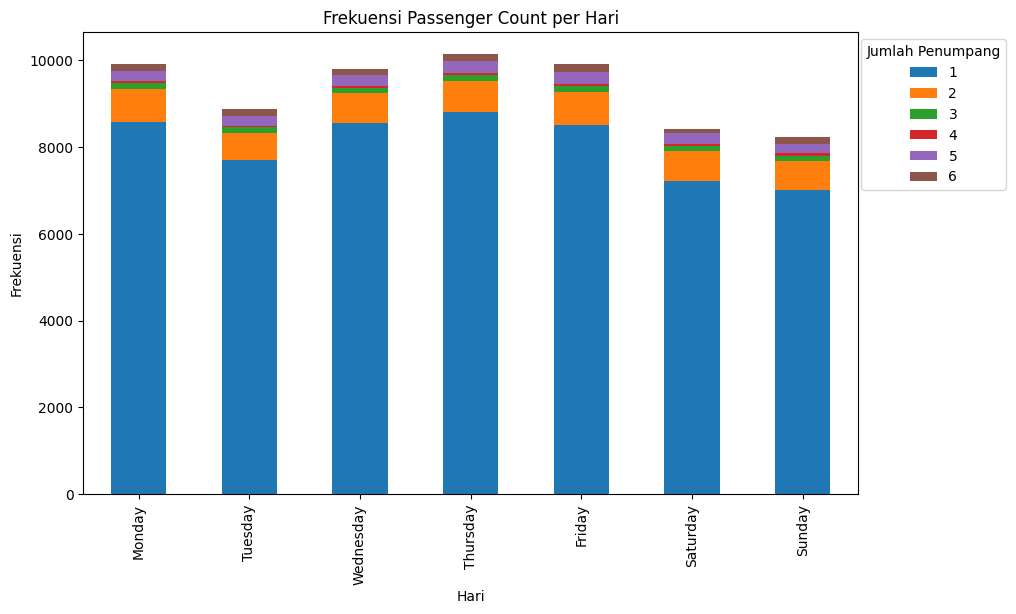

In [60]:
seq = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
frekuensi_hari = frekuensi_hari.drop('Total', axis=1)
frekuensi_hari = frekuensi_hari.reindex(seq)
ax = frekuensi_hari.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Frekuensi Passenger Count per Hari')
plt.xlabel('Hari')
plt.ylabel('Frekuensi')
plt.legend(title='Jumlah Penumpang', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Dapat kita lihat bahwa pada hari Sabtu dan Minggu terdapat penurunan frekuensi perjalanan taksi. Namun dari sisi `passenger_count` tidak ada perubahannya, penggunaan masih tetap dominan untuk perorangan bahkan di hari libur sekalipun. Agar analisa lebih jelas, mari kita lihat data per-tanggalnya

In [61]:
df['tanggal'] = df['lpep_pickup_datetime'].dt.date
freq_daily = df.groupby('tanggal')['passenger_count'].value_counts().unstack(fill_value=0)
freq_daily

passenger_count     1    2   3   4   5   6
tanggal                                   
2023-01-01       1224  104  23  18  42  28
2023-01-02       1337  120  24  12  36  22
2023-01-03       1782  169  38   7  61  48
2023-01-04       2080  163  33   6  51  33
2023-01-05       2056  173  41  13  81  39
2023-01-06       2149  204  35  11  76  55
2023-01-07       1850  150  30   9  64  18
2023-01-08       1417   99  24  17  46  29
2023-01-09       1909  141  28  13  66  34
2023-01-10       1920  123  20   4  62  29
2023-01-11       2134  174  29  12  73  42
2023-01-12       2216  145  35  11  67  29
2023-01-13       2154  210  36  11  69  47
2023-01-14       1829  188  27  13  63  19
2023-01-15       1489  160  19  12  44  31
2023-01-16       1366  133  15  15  20  22
2023-01-17       1918  160  39  11  56  41
2023-01-18       2033  163  30  14  52  36
2023-01-19       2278  193  39  13  57  43
2023-01-20       2139  170  34  10  55  45
2023-01-21       1813  171  40  13  61  24
2023-01-22       1491  164  26  10  37  23
2023-01-23       2042  184  31   8  66  40
2023-01-24       2088  171  30  14  48  42
2023-01-25       2319  179  29  10  70  40
2023-01-26       2255  202  35  11  66  43
2023-01-27       2060  194  32   9  78  36
2023-01-28       1731  169  35  11  58  21
2023-01-29       1401  130  29  15  40  32
2023-01-30       1928  178  32  12  41  32

Hari libur nasional (selain hari Sabtu dan Minggu) di negara bagian New York adalah:
* 1 Januari 2023 -> Tahun Baru
* 2 Januari 2023 -> Libur Bersama Tahun Baru
* 16 Januari 2023 -> Martin Luther King Jr. Day

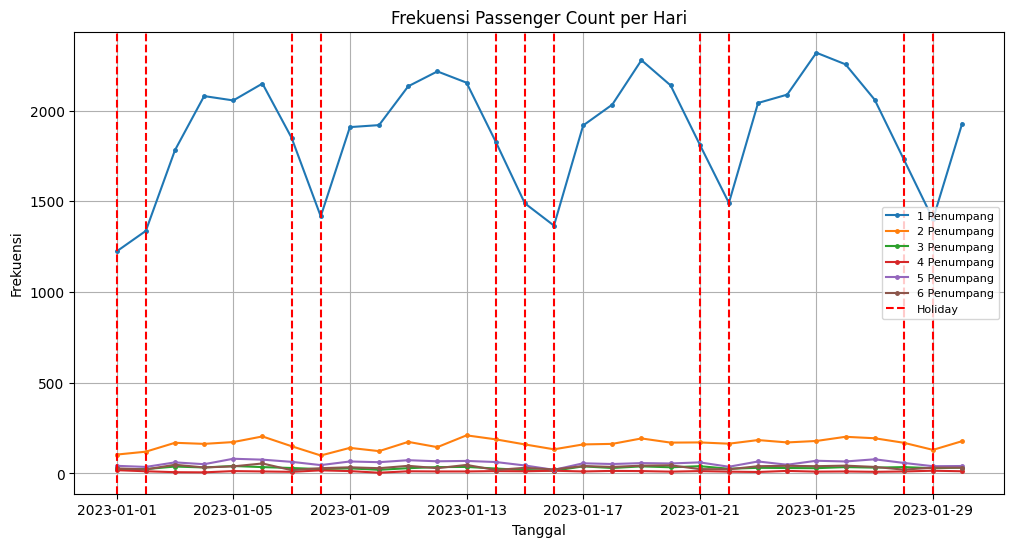

In [62]:
plt.figure(figsize=(12, 6))
for passenger_count in freq_daily.columns:
    plt.plot(freq_daily.index, 
             freq_daily[passenger_count], 
             label=f'Passenger Count {passenger_count}', 
             marker='.', markersize=5)
    
# Menandai hari libur dengan mark khusus
holidays = pd.to_datetime(['2023-01-01',
            '2023-01-02',
            '2023-01-07',
            '2023-01-08',
            '2023-01-14',
            '2023-01-15',
            '2023-01-16',
            '2023-01-21',
            '2023-01-22',
            '2023-01-28',
            '2023-01-29'])
for date in holidays:
    plt.axvline(x=date, color='r', linestyle='--', label='Holiday')
plt.xlabel('Tanggal')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Passenger Count per Hari')
plt.legend([f'{count} Penumpang' for count in freq_daily.columns] + ['Holiday'], 
           loc='center right', 
           prop={'size': 8})
plt.grid(True)
plt.show()

Setelah kita melihat line plot untuk data permasing-masing tanggal. Dapat disimpulkan, bahwa bahkan di hari libur sekalipun, penggunaan taksi tetap masih dominan untuk perorangan.

**Saran**: Apabila ingin meningkatkan promosi penggunaan taksi dalam jumlah grup atau lebih dari 2 orang, pihak TLC dapat mempromosikan apabila kita menggunakan taksi dapat lebih murah apabila makin banyak penumpangnya.

## 2. Analisa titik jemput terbanyak

In [63]:
# Merging berdasarakan kolom PULocationID
gdf = gpd.read_file('NYC_Taxi_Zones.geojson') # Import dataset berisi latitude dan longitude
gdf['latitude'] = gdf['geometry'].centroid.y
gdf['longitude'] = gdf['geometry'].centroid.x
gdf['location_id']=gdf['location_id'].astype('int64')
df3 = df.merge(gdf[['location_id', 'latitude', 'longitude', 'borough', 'zone']], left_on='PULocationID', right_on='location_id', how='left')
df3.dropna(subset=['latitude', 'longitude'], inplace=True)
df3

VendorID lpep_pickup_datetime lpep_dropoff_datetime  RatecodeID  \
0             2  2023-01-01 00:26:10   2023-01-01 00:37:11           1   
1             2  2023-01-01 00:51:03   2023-01-01 00:57:49           1   
2             2  2023-01-01 00:35:12   2023-01-01 00:41:32           1   
3             1  2023-01-01 00:13:14   2023-01-01 00:19:03           1   
4             1  2023-01-01 00:33:04   2023-01-01 00:39:02           1   
...         ...                  ...                   ...         ...   
65319         2  2023-01-30 21:54:00   2023-01-30 22:04:00           1   
65320         2  2023-01-30 21:34:00   2023-01-30 21:46:00           1   
65321         2  2023-01-30 21:56:00   2023-01-30 22:09:00           1   
65322         2  2023-01-30 22:36:00   2023-01-30 23:01:00           1   
65323         2  2023-01-30 22:25:00   2023-01-30 22:38:00           1   

       PULocationID  DOLocationID  passenger_count  trip_distance  \
0               166           143                1           2.58   
1                24            43                1           1.81   
2               223           179                1           0.00   
3                41           238                1           1.30   
4                41            74                1           1.10   
...             ...           ...              ...            ...   
65319             7           229                1           3.08   
65320            42           239                1           3.05   
65321           244            42                1           2.26   
65322            33           100                1           5.12   
65323           146           226                1           1.73   

       fare_amount  extra  ...  payment_type  trip_type  congestion_surcharge  \
0            14.90    1.0  ...             1        1.0                  2.75   
1            10.70    1.0  ...             1        1.0                  0.00   
2             7.20    1.0  ...             1        1.0                  0.00   
3             6.50    0.5  ...             1        1.0                  0.00   
4             6.00    0.5  ...             1        1.0                  0.00   
...            ...    ...  ...           ...        ...                   ...   
65319        14.91    0.0  ...             1        1.0                  0.00   
65320        15.19    0.0  ...             1        1.0                  0.00   
65321        14.65    0.0  ...             1        1.0                  0.00   
65322        20.08    0.0  ...             1        1.0                  0.00   
65323        14.58    0.0  ...             1        1.0                  0.00   

         hari     tanggal  location_id   latitude  longitude    borough  \
0      Sunday  2023-01-01        166.0  40.809457 -73.961764  Manhattan   
1      Sunday  2023-01-01         24.0  40.801970 -73.965480  Manhattan   
2      Sunday  2023-01-01        223.0  40.777427 -73.905408     Queens   
3      Sunday  2023-01-01         41.0  40.804334 -73.951292  Manhattan   
4      Sunday  2023-01-01         41.0  40.804334 -73.951292  Manhattan   
...       ...         ...          ...        ...        ...        ...   
65319  Monday  2023-01-30          7.0  40.761493 -73.919694     Queens   
65320  Monday  2023-01-30         42.0  40.818258 -73.940772  Manhattan   
65321  Monday  2023-01-30        244.0  40.841709 -73.941399  Manhattan   
65322  Monday  2023-01-30         33.0  40.695798 -73.995250   Brooklyn   
65323  Monday  2023-01-30        146.0  40.754243 -73.934829     Queens   

                                zone  
0                Morningside Heights  
1                       Bloomingdale  
2                           Steinway  
3                     Central Harlem  
4                     Central Harlem  
...                              ...  
65319                        Astoria  
65320           Central Harlem North  
65321       Washington Heights South  
65322               Brook

In [64]:
df3 = df3.drop(['VendorID',
                 'RatecodeID',
                 'PULocationID',
                 'DOLocationID',
                 'passenger_count',
                 'extra',
                 'mta_tax',
                 'tip_amount',
                 'tolls_amount',
                 'improvement_surcharge', 
                 'total_amount', 
                 'payment_type',
                 'trip_type',
                 'congestion_surcharge',
                 ], axis=1)

In [65]:
df3

lpep_pickup_datetime lpep_dropoff_datetime  trip_distance  fare_amount  \
0      2023-01-01 00:26:10   2023-01-01 00:37:11           2.58        14.90   
1      2023-01-01 00:51:03   2023-01-01 00:57:49           1.81        10.70   
2      2023-01-01 00:35:12   2023-01-01 00:41:32           0.00         7.20   
3      2023-01-01 00:13:14   2023-01-01 00:19:03           1.30         6.50   
4      2023-01-01 00:33:04   2023-01-01 00:39:02           1.10         6.00   
...                    ...                   ...            ...          ...   
65319  2023-01-30 21:54:00   2023-01-30 22:04:00           3.08        14.91   
65320  2023-01-30 21:34:00   2023-01-30 21:46:00           3.05        15.19   
65321  2023-01-30 21:56:00   2023-01-30 22:09:00           2.26        14.65   
65322  2023-01-30 22:36:00   2023-01-30 23:01:00           5.12        20.08   
65323  2023-01-30 22:25:00   2023-01-30 22:38:00           1.73        14.58   

         hari     tanggal  location_id   latitude  longitude    borough  \
0      Sunday  2023-01-01        166.0  40.809457 -73.961764  Manhattan   
1      Sunday  2023-01-01         24.0  40.801970 -73.965480  Manhattan   
2      Sunday  2023-01-01        223.0  40.777427 -73.905408     Queens   
3      Sunday  2023-01-01         41.0  40.804334 -73.951292  Manhattan   
4      Sunday  2023-01-01         41.0  40.804334 -73.951292  Manhattan   
...       ...         ...          ...        ...        ...        ...   
65319  Monday  2023-01-30          7.0  40.761493 -73.919694     Queens   
65320  Monday  2023-01-30         42.0  40.818258 -73.940772  Manhattan   
65321  Monday  2023-01-30        244.0  40.841709 -73.941399  Manhattan   
65322  Monday  2023-01-30         33.0  40.695798 -73.995250   Brooklyn   
65323  Monday  2023-01-30        146.0  40.754243 -73.934829     Queens   

                                zone  
0                Morningside Heights  
1                       Bloomingdale  
2                           Steinway  
3                     Central Harlem  
4                     Central Harlem  
...                              ...  
65319                        Astoria  
65320           Central Harlem North  
65321       Washington Heights South  
65322               Brooklyn Heights  
65323  Long Island City/Queens Plaza  

[65185 rows x 11 columns]

Dari dataset tersebut, saya ingin mencari tahu, dari mana biasanya penumpang taksi naik. Dan melihat, apakah jumlah trip engagement dari pickup location tersebut berkorelasi dengan jumlah pendapatan (fare_amount) untuk masing-masing `location_id` pada Bulan Januari 2023 sebelum ditambahkan dengan faktor lainnya.

In [66]:
top5 = df3.groupby(['location_id','zone', 'borough','latitude','longitude']).size().sort_values(ascending=False).reset_index(name='total_trip')
total_fare_locid = df3.groupby('location_id')['fare_amount'].sum().reset_index(name='total_fare')
top5 = top5.merge(total_fare_locid, on='location_id', how='left')
top5['average_fare_per_trip']=top5['total_fare']/top5['total_trip']
top_5 = top5.head()
top_5

location_id                 zone    borough   latitude  longitude  \
0         74.0    East Harlem North  Manhattan  40.801169 -73.937346   
1         75.0    East Harlem South  Manhattan  40.790011 -73.945750   
2         41.0       Central Harlem  Manhattan  40.804334 -73.951292   
3         95.0         Forest Hills     Queens  40.721432 -73.847669   
4        166.0  Morningside Heights  Manhattan  40.809457 -73.961764   

   total_trip  total_fare  average_fare_per_trip  
0       12785   172223.87              13.470776  
1        8768   112745.35              12.858731  
2        3891    49128.87              12.626284  
3        3685    49834.30              13.523555  
4        3684    50552.61              13.722207

In [67]:
top_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   location_id            5 non-null      float64
 1   zone                   5 non-null      object 
 2   borough                5 non-null      object 
 3   latitude               5 non-null      float64
 4   longitude              5 non-null      float64
 5   total_trip             5 non-null      int64  
 6   total_fare             5 non-null      float64
 7   average_fare_per_trip  5 non-null      float64
dtypes: float64(5), int64(1), object(2)
memory usage: 452.0+ bytes


In [68]:
nyc1 = folium.Map(location = [40.730610, -73.935242], zoom_start = 10)
folium.GeoJson(gdf).add_to(nyc1)
heat_data = top_5[['latitude', 'longitude']].values.tolist()
bins = [0, 50, 100, 200, 500, 1000]
HeatMap(heat_data, bins=bins, gradient={0.2: 'blue', 0.4: 'green', 0.6: 'orange', 1: 'red'}).add_to(nyc1)
nyc1

In [69]:
# Menghitung korelasi antara jumlah trip dan jumlah pendapatan
correlation = top_5['total_trip'].corr(top_5['total_fare'])
print(f"Korelasi antara jumlah perjalanan dan total tarif: {correlation}")

Korelasi antara jumlah perjalanan dan total tarif: 0.9988161827446977


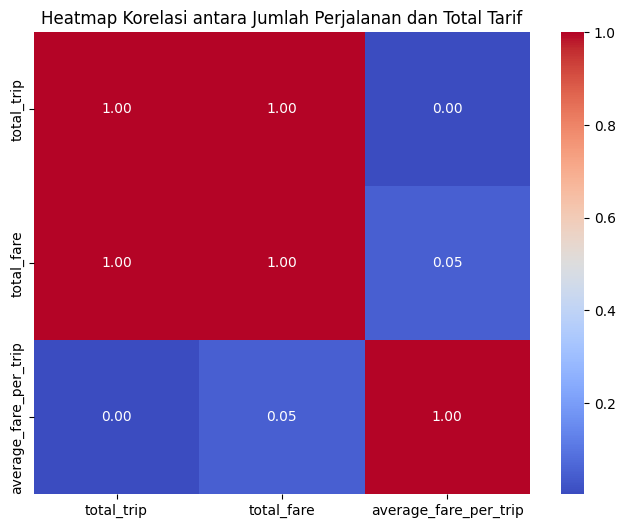

In [70]:
plt.figure(figsize=(8, 6))
sns.heatmap(top_5[['total_trip','total_fare','average_fare_per_trip']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi antara Jumlah Perjalanan dan Total Tarif')
plt.show()

Berdasarkan heatmap tersebut, dapat kita ketahui bahwa jumlah trip perhari dari lokasi penjemputan lima teratas, memiliki korelasi yang kuat dengan jumlah dari tarif taksi sebelum pertambahan pajak dan biaya tambahan lainnya.

Namun alangkah baiknya, kita meneliti lebih jauh lagi, apakah ada waktu tertentu dimana permintaan taksi jauh lebih tinggi dari waktu lain. Untuk melakukannya, saya akan membagi zona waktu perhari menjadi 4 bagian:

In [71]:
# Melihat total trip berdasarkan kurun waktu tertentu
def categorize_time(hour):
    if 6 <= hour < 9:
        return '06.00-09.00'
    elif 9 <= hour < 12:
        return '09.00-12.00'
    elif 12 <= hour < 15:
        return '12.00-15.00'
    elif 15 <= hour < 18:
        return '15.00-18.00'
    elif 18 <= hour < 24:
        return 'Malam'
    else:
        return 'Larut Malam'

df3['time_category'] = df3['lpep_pickup_datetime'].dt.hour.apply(categorize_time)
urutan = ['Larut Malam','06.00-09.00','09.00-12.00','12.00-15.00', '15.00-18.00','Malam']
df3['time_category'] = pd.Categorical(df3['time_category'], categories=urutan, ordered=True)
triptotal_time = df3.groupby(['location_id', 'time_category']).size().reset_index(name='total_trip')

In [72]:
top_5a = top_5.drop(['total_trip', 'total_fare','average_fare_per_trip','latitude','longitude'], axis=1)
top_5a = top_5a.merge(triptotal_time, on='location_id', how='left')
top_5a

location_id                 zone    borough time_category  total_trip
0          74.0    East Harlem North  Manhattan   Larut Malam         250
1          74.0    East Harlem North  Manhattan   06.00-09.00        2610
2          74.0    East Harlem North  Manhattan   09.00-12.00        2567
3          74.0    East Harlem North  Manhattan   12.00-15.00        2111
4          74.0    East Harlem North  Manhattan   15.00-18.00        2456
5          74.0    East Harlem North  Manhattan         Malam        2791
6          75.0    East Harlem South  Manhattan   Larut Malam         208
7          75.0    East Harlem South  Manhattan   06.00-09.00         623
8          75.0    East Harlem South  Manhattan   09.00-12.00        1315
9          75.0    East Harlem South  Manhattan   12.00-15.00        1646
10         75.0    East Harlem South  Manhattan   15.00-18.00        2538
11         75.0    East Harlem South  Manhattan         Malam        2438
12         41.0       Central Harlem  Manhattan   Larut Malam         127
13         41.0       Central Harlem  Manhattan   06.00-09.00         506
14         41.0       Central Harlem  Manhattan   09.00-12.00         797
15         41.0       Central Harlem  Manhattan   12.00-15.00         857
16         41.0       Central Harlem  Manhattan   15.00-18.00         812
17         41.0       Central Harlem  Manhattan         Malam         792
18         95.0         Forest Hills     Queens   Larut Malam         285
19         95.0         Forest Hills     Queens   06.00-09.00         202
20         95.0         Forest Hills     Queens   09.00-12.00         418
21         95.0         Forest Hills     Queens   12.00-15.00         632
22         95.0         Forest Hills     Queens   15.00-18.00         908
23         95.0         Forest Hills     Queens         Malam        1240
24        166.0  Morningside Heights  Manhattan   Larut Malam          34
25        166.0  Morningside Heights  Manhattan   06.00-09.00         293
26        166.0  Morningside Heights  Manhattan   09.00-12.00         743
27        166.0  Morningside Heights  Manhattan   12.00-15.00         837
28        166.0  Morningside Heights  Manhattan   15.00-18.00         945
29        166.0  Morningside Heights  Manhattan         Malam         832

Kita telah berhasil untuk membagi 5 teratas jumlah pickup location berdasarkan satuan waktu yang kita tentukan. Saya akan membuat visualisasinnya agar proses analisa menjadi lebih mudah.

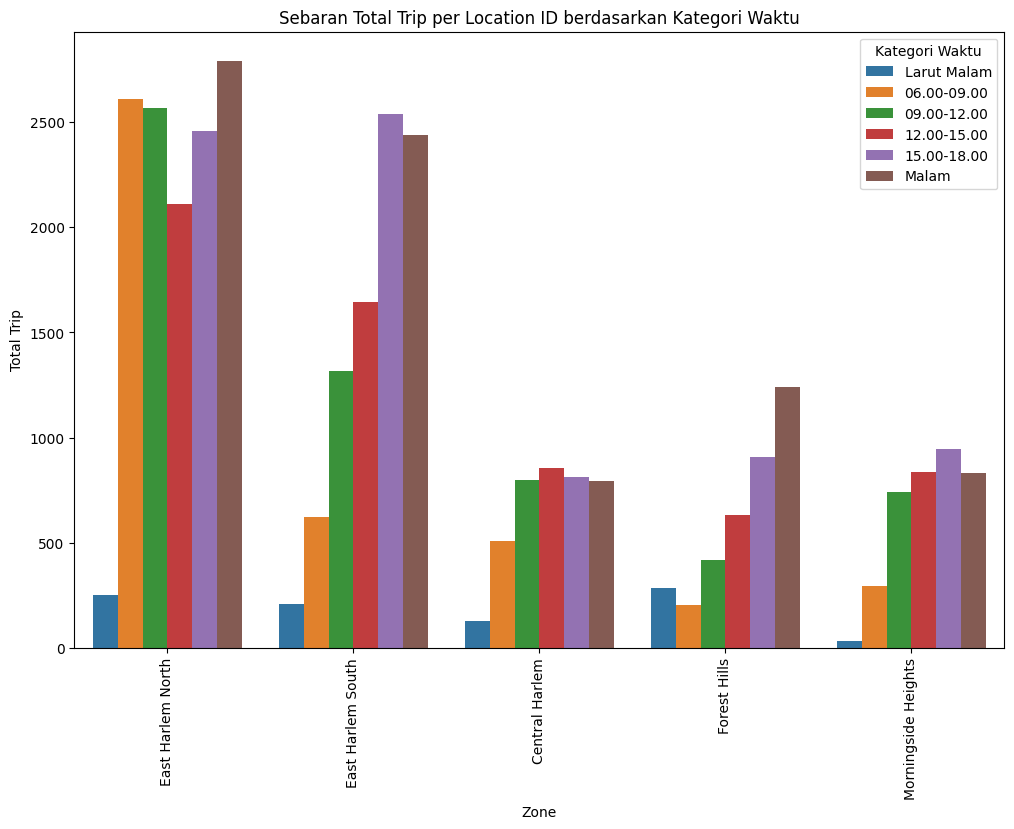

In [73]:
# Membuat bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='zone', y='total_trip', hue='time_category', data=top_5a)
plt.title('Sebaran Total Trip per Location ID berdasarkan Kategori Waktu')
plt.xlabel('Zone')
plt.ylabel('Total Trip')
plt.xticks(rotation=90)
plt.legend(title='Kategori Waktu')
plt.show()

Dapat kita lihat, bahwa setelah data 5 teratas lokasi penjemputan dibagi menjadi beberapa zona waktu. Dapat kita simpulkan bahwa:

**Berdasarkan Lokasi**
* Pada masing-masing lokasi penjemputan, terjadi perbedaan waktu puncak pemesanan taxi.
    * Untuk daerah ***East Harlem North*** puncaknya di malam hari (18.00-24.00)
    * Untuk daerah ***East Harlem South*** puncaknya di pukul 15.00-18.00. Nilainya di rentang waktu ini bahkan lebih tinggi daripada total pickup di ***East Harlem North*** di rentang waktu yang sama.
    * Untuk daerah ***Central Harlem*** puncaknya di pukul 12.00-15.00
    * Untuk daerah ***Morningside Heights*** puncaknya di pukul 15.00-18.00
    * Untuk daerah ***Forest Hills*** puncaknya di malam hari (18.00-24.00)

**Berdasarkan Waktu**
* Jam 06.00 - 15.00 dan malam hari, titik penjemputan terbanyak terdapat di  ***East Harlem North***
* Pada waktu 15.00-18.00 titik penjemputan terbanyak adalah di ***East Harlem South***
* Pada wakt larut malam (00.00-06.00) titik penjemputan terbanyak adalah di ***Forest Hills***

Disini dapat diasumsikan secara grafik memang seharusnya bisa kita mengambil volume yang terbesar untuk memaksimalkan pendapatan. Namun untuk efektif atau tidaknya memaksimalkan pendapatan dengan cara tersebut, saya akan mencoba melakukan uji ANOVA One-Way untuk membandingkan apakah terdapat perbedaan yang signifikan dalam rata-rata fare amount per lokasi pickup. Hipotesis yang diuji adalah

* H0 = Terdapat perbedaan yang signifikan antara total pendapatan di pickup location
* H1 = Tidak adanya perbedaan yang signifikan antara total pendapatan di pickup location

In [74]:
# Uji ANOVA One-way pada rata-rata tarif per-perjalanan
f_statistic, p_value = f_oneway(top_5['average_fare_per_trip'][top_5['location_id'] == 74],
                                 top_5['average_fare_per_trip'][top_5['location_id'] == 75],
                                 top_5['average_fare_per_trip'][top_5['location_id'] == 41],
                                 top_5['average_fare_per_trip'][top_5['location_id'] == 166],
                                 top_5['average_fare_per_trip'][top_5['location_id'] == 95])

alpha = 0.05  # Tingkat signifikansi
if p_value < alpha:
    print("Terdapat perbedaan yang signifikan antara total pendapatan di pickup location")
else:
    print("Tidak adanya perbedaan yang signifikan antara total pendapatan di pickup location")


Tidak adanya perbedaan yang signifikan antara total pendapatan di pickup location


**Saran**: Setelah dilakukan uji ANOVA One-way, ternyata tidak ada perbedaan signifikan antara mean-nya. Sehingga dapat kita simpulkan bahwa kita dapat mengicar volume yang lebih besar untuk memaksimalkan pendapatan, sehingga ***East Harlem*** baik itu South atau North sudah sepatutnya menjadi fokus untuk penempatan armada taksi standby.

In [75]:
with pd.ExcelWriter('data_for_tableau.xlsx', engine='xlsxwriter') as excel_writer:      # Excel name: 'data_for_tableau.xlsx'
    for index, df in enumerate([df, 
                                df2,
                                frekuensi_hari,
                                freq_daily,
                                df3, 
                                top_5, 
                                top_5a]):
        df.to_excel(excel_writer, sheet_name=f'df{index}', index=False)                  # Export dataframes to each excel sheets

print(f'DataFrames has been exported to excel')

DataFrames has been exported to excel
